In [55]:
!pip install pandas numpy matplotlib seaborn pyyaml scipy scikit-learn joblib ipywidgets

# D&D 5e 2024 Challenge Rating Analysis

This notebook is designed to analyze monster stat blocks from the 2024 D&D 5e monster manual to reverse engineer the Challenge Rating (CR) calculation rules. The goal is to help design balanced homebrew monsters by understanding the patterns between monster statistics and their assigned CR values.

## Setup and Imports

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import os
import glob
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import ipywidgets as widgets
from IPython.display import display

# Set visualization styles
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# Define a standard color palette
colors = sns.color_palette("viridis", 10)

## 1. Data Collection and Loading

In [2]:
def load_monster_data(directory_path):
    """
    Load all monster stat blocks from YAML files in the specified directory
    """
    monster_files = glob.glob(os.path.join(directory_path, "*.yaml"))
    monsters = []
    
    for file_path in monster_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                monster_data = yaml.safe_load(file)
                monsters.append(monster_data)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    print(f"Loaded {len(monsters)} monster stat blocks")
    return monsters

# Specify the directory containing your monster YAML files
monster_dir = "../../monster_stats_2024"  # Update this to your actual path
monsters = load_monster_data(monster_dir)

Loaded 503 monster stat blocks


## 2. Data Preprocessing and Feature Extraction

### Define action classification keywords

In [3]:
# Define keywords for action classification
offensive_keywords = ['attack', 'damage', 'hit', 'strike', 'blast', 'breath', 'ray', 'beam', 'smash', 'slash']
defensive_keywords = ['heal', 'resistance', 'regain', 'restore', 'shield', 'armor', 'protect', 'cure', 'block']
control_keywords = ['move', 'teleport', 'terrain', 'difficult', 'immobilize', 'restrain', 'command', 'summon',
                    'conjure', 'charm', 'fear', 'frighten', 'stun', 'prone', 'grapple']

### Function to classify actions by type

In [4]:
def classify_action(action, offensive_keywords, defensive_keywords, control_keywords):
    """
    Classify an action as offensive, defensive, control, or utility
    based on keywords and structure
    """
    name = action.get('name', '').lower()
    description = action.get('description', '').lower()
    text = name + ' ' + description
    
    # Check if this is a direct attack
    has_attack = 'attack' in action and (action['attack'].get('is_melee') or action['attack'].get('is_ranged'))
    has_damage = 'hit' in action and action['hit'].get('damage')
    
    if has_attack or has_damage or any(keyword in text for keyword in offensive_keywords):
        return 'offensive'
    elif any(keyword in text for keyword in defensive_keywords):
        return 'defensive'
    elif any(keyword in text for keyword in control_keywords):
        return 'control'
    else:
        return 'utility'

### Calculate damage per round for offensive actions

In [5]:
def calculate_action_dpr(action):
    """
    Calculate the estimated Damage Per Round (DPR) for an offensive action
    """
    damage = 0
    
    # Handle direct damage calculations if we have a damage formula
    if 'hit' in action and action['hit'].get('damage'):
        damage_str = action['hit']['damage']
        damage_match = re.findall(r'(\d+)d(\d+)(?:\s*\+\s*(\d+))?', damage_str)
        
        for dice_match in damage_match:
            dice_num = int(dice_match[0])
            dice_size = int(dice_match[1])
            mod_value = int(dice_match[2]) if len(dice_match) > 2 and dice_match[2] else 0
            
            # Average dice value is (n+1)/2 where n is the die size
            dice_avg = (dice_num * (dice_size + 1)) / 2
            damage += dice_avg + mod_value
    
    # If we have an attack bonus, calculate hit probability
    hit_probability = 0.65  # Default hit probability (~65% chance to hit)
    if 'attack' in action and action['attack'].get('bonus'):
        # Each +1 to hit increases hit chance by ~5% (simplified calculation)
        hit_bonus = action['attack']['bonus']
        hit_probability = min(0.95, 0.5 + (hit_bonus * 0.05))
    
    # If this is a save-based effect, estimate success rate
    if 'mechanics' in action and action['mechanics'].get('save_dc'):
        # Higher DC means higher success rate
        dc = action['mechanics']['save_dc']
        save_success = min(0.8, 0.4 + ((dc - 10) * 0.05))  # DC 10 is ~40% save rate
        hit_probability = save_success
    
    # Adjust for area effects, which tend to hit multiple targets
    aoe_keywords = ['all', 'each', 'every', 'creatures', 'within', 'area', 'cone', 'cube', 'sphere', 'radius']
    if any(keyword in action.get('description', '').lower() for keyword in aoe_keywords):
        # Assume AoE hits 2.5 targets on average
        damage *= 2.5
    
    # Apply hit probability
    expected_damage = damage * hit_probability
    
    # Factor in limited uses (e.g., recharge abilities)
    if 'usage' in action:
        usage_type = action['usage'].get('type')
        if usage_type == 'recharge':
            # Recharge X-6: probability (7-X)/6
            if action['usage'].get('range'):
                min_roll = min(action['usage']['range'])
                recharge_prob = (7 - min_roll) / 6
                expected_damage *= recharge_prob
        elif usage_type in ['per_day', 'per_short_rest', 'per_long_rest']:
            # For limited use abilities, assume they're used optimally
            # but account for their limited availability
            uses = action['usage'].get('times', 1)
            # Assume 3 rounds per encounter, monsters likely won't be encountered again in the same day
            expected_damage *= min(1.0, uses / 3)
    
    return expected_damage

### Analyze monster actions and calculate total offensive output

In [6]:
def analyze_monster_actions(monster_data):
    """
    Analyze a monster's actions by categorizing them by function and estimating their impact
    """
    action_analysis = {
        'offensive': {'count': 0, 'total_dpr': 0, 'actions': []},
        'defensive': {'count': 0, 'actions': []},
        'control': {'count': 0, 'actions': []},
        'utility': {'count': 0, 'actions': []}
    }
    
    # Process standard actions
    for action in monster_data.get('actions', {}).get('standard', []):
        action_type = classify_action(action, offensive_keywords, defensive_keywords, control_keywords)
        action_analysis[action_type]['count'] += 1
        action_analysis[action_type]['actions'].append(action)
        
        # Calculate DPR for offensive actions
        if action_type == 'offensive' and 'hit' in action and action['hit'].get('damage'):
            action_analysis['offensive']['total_dpr'] += calculate_action_dpr(action)
    
    # Process bonus actions
    for action in monster_data.get('actions', {}).get('bonus_actions', []):
        action_type = classify_action(action, offensive_keywords, defensive_keywords, control_keywords)
        action_analysis[action_type]['count'] += 1
        action_analysis[action_type]['actions'].append(action)
        
        # Calculate DPR for offensive actions, weighted for being a bonus action
        if action_type == 'offensive' and 'hit' in action and action['hit'].get('damage'):
            action_analysis['offensive']['total_dpr'] += calculate_action_dpr(action)
    
    # Process reactions
    for action in monster_data.get('actions', {}).get('reactions', []):
        action_type = classify_action(action, offensive_keywords, defensive_keywords, control_keywords)
        action_analysis[action_type]['count'] += 1
        action_analysis[action_type]['actions'].append(action)
        
        # Calculate DPR for offensive reactions (assuming it triggers once per round)
        if action_type == 'offensive' and 'hit' in action and action['hit'].get('damage'):
            # Apply a probability factor for reactions (they might not trigger every round)
            reaction_probability = 0.5  # Assume 50% chance of reaction triggering
            action_analysis['offensive']['total_dpr'] += calculate_action_dpr(action) * reaction_probability
    
    # Process legendary actions
    if 'legendary_actions' in monster_data:
        slots = monster_data['legendary_actions'].get('slots_per_round', 3)
        legendary_actions = monster_data['legendary_actions'].get('actions', [])
        
        # Count all legendary actions by type
        for action in legendary_actions:
            action_type = classify_action(action, offensive_keywords, defensive_keywords, control_keywords)
            action_analysis[action_type]['count'] += 1
            action_analysis[action_type]['actions'].append(action)
            
            # For offensive legendary actions, estimate their contribution to DPR
            if action_type == 'offensive' and 'cost' in action:
                # Calculate DPR based on legendary action cost and slots available
                # Prioritize offensive actions for DPR calculation
                slots_used = min(slots, action['cost'])
                if slots_used > 0:
                    action_dpr = calculate_action_dpr(action) * (slots_used / action['cost'])
                    action_analysis['offensive']['total_dpr'] += action_dpr
                    slots -= slots_used
    
    # Process lair actions
    if 'lair_actions' in monster_data:
        for action in monster_data['lair_actions'].get('actions', []):
            action_type = classify_action(action, offensive_keywords, defensive_keywords, control_keywords)
            action_analysis[action_type]['count'] += 1
            action_analysis[action_type]['actions'].append(action)
            
            # For offensive lair actions, estimate their contribution to DPR
            # (assuming one lair action per round)
            if action_type == 'offensive':
                # Lair actions often have a 1-in-X chance or are on initiative count
                # Assume 1/3 chance for a specific lair action
                lair_probability = 0.33
                action_analysis['offensive']['total_dpr'] += calculate_action_dpr(action) * lair_probability
    
    return action_analysis

### Estimate spell damage for spellcasting monsters

In [7]:
def estimate_cantrip_damage(spell_name, cr):
    """
    Estimate the damage for common cantrips based on CR
    """
    # CR determines cantrip tier (how many damage dice)
    if isinstance(cr, str) and '/' in cr:
        # Handle fractional CR
        num, denom = cr.split('/')
        cr_value = float(num) / float(denom)
    else:
        cr_value = float(cr)
    
    # Calculate cantrip tier based on equivalent character level
    if cr_value < 5:
        tier = 1
    elif cr_value < 11:
        tier = 2
    elif cr_value < 17:
        tier = 3
    else:
        tier = 4
    
    # Damage estimates for common cantrips
    cantrip_base_damage = {
        'fire bolt': 5.5,  # 1d10
        'eldritch blast': 5.5,  # 1d10
        'chill touch': 4.5,  # 1d8
        'ray of frost': 4.5,  # 1d8
        'sacred flame': 4.5,  # 1d8
        'shocking grasp': 4.5,  # 1d8
        'poison spray': 6.5,  # 1d12
        'acid splash': 3.5,  # 1d6
        'vicious mockery': 2.5,  # 1d4
    }
    
    # If the spell isn't in our list, use a default value
    base_damage = cantrip_base_damage.get(spell_name, 0)
    if base_damage == 0:
        # Check if it contains common damage cantrip words
        damage_keywords = ['bolt', 'ray', 'blast', 'touch', 'flame', 'grasp', 'spray', 'splash']
        if any(keyword in spell_name for keyword in damage_keywords):
            base_damage = 4.5  # Default to d8 damage
    
    # Scale by tier
    return base_damage * tier

def estimate_spell_level_for_frequency(frequency, cr):
    frequency_to_level = {
        '3/day': 1,    # Usually 1st level
        '2/day': 2,    # Usually 2nd level
        '1/day': 3     # Usually 3rd level or higher
    }
    
    # For 1/day spells, scale with CR to represent higher level spells for higher CR monsters
    estimated_level = frequency_to_level.get(frequency, 0)
    
    # Adjust for CR if it's a 1/day ability (higher CR = higher level spell)
    if cr is not None and not '/' in cr:
        # Convert cr to float if it's a string
        cr_multiplier = max(1, float(cr) / 10)  # CR 30 is the highest in 5e
        estimated_level += min(9, int(cr_multiplier * estimated_level))

    return estimated_level

def estimate_spell_damage(spell_name, level=None, frequency=None, cr=None):
    """
    Estimate the damage for common spells based on their level or usage frequency.
    
    Parameters:
    -----------
    spell_name : str
        Name of the spell (lowercase)
    level : int, optional
        Spell level (0-9)
    frequency : str, optional
        Usage frequency ('at_will', '3/day', '2/day', '1/day', etc.)
    cr : float or str, optional
        Challenge rating of the monster (needed for frequency-based estimation)
    
    Returns:
    --------
    float
        Estimated average damage per casting
    """
    # Common damage spells and their base damage
    spell_base_damage = {
        'magic missile': 10.5,  # 3 * (1d4+1)
        'burning hands': 10.5,  # 3d6
        'thunderwave': 9,  # 2d8
        'scorching ray': 21,  # 3 * 2d6 (level 2)
        'fireball': 28,  # 8d6 (level 3)
        'lightning bolt': 28,  # 8d6 (level 3)
        'ice storm': 23,  # 2d8 + 4d6 (level 4)
        'cone of cold': 36,  # 8d8 (level 5)
        'chain lightning': 45,  # 10d8 (level 6)
        'fire storm': 38.5,  # 7d10 (level 7)
        'sunburst': 42,  # 12d6 (level 8)
        'meteor swarm': 140,  # 40d6 (level 9)
        # Add more common damage spells here
    }
    
    # Default damage by spell level (average damage per cast)
    default_damage_by_level = {
        0: 5.5,   # ~1d10 (cantrip, scales with level)
        1: 10.5,  # ~3d6
        2: 21,    # ~6d6
        3: 28,    # ~8d6
        4: 35,    # ~10d6
        5: 42,    # ~12d6
        6: 49,    # ~14d6
        7: 56,    # ~16d6
        8: 63,    # ~18d6
        9: 70     # ~20d6
    }
    
    # If we have a direct match in our spell database, use that
    if spell_name in spell_base_damage:
        return spell_base_damage[spell_name]
    
    # If level is provided, use level-based estimation
    if level is not None:
        # Cantrips scale with CR/level
        if level == 0 and cr is not None:
            # Convert cr to float if it's a string (e.g., "1/2")
            if isinstance(cr, str) and '/' in cr:
                num, denom = cr.split('/')
                cr_value = float(num) / float(denom)
            else:
                cr_value = float(cr)
                
            # Scale cantrip damage based on CR
            if cr_value < 5:
                tier = 1
            elif cr_value < 11:
                tier = 2
            elif cr_value < 17:
                tier = 3
            else:
                tier = 4
                
            return default_damage_by_level[0] * tier
        
        # For leveled spells, use the default damage for that level
        return default_damage_by_level.get(level, 0)
    
    # If frequency is provided, estimate level and use level-based estimation
    if frequency is not None:
        # Map frequency to approximate spell level
        estimated_level = estimate_spell_level_for_frequency(frequency, cr)
        
        # Check if it's a damage spell based on keywords
        damage_keywords = ['bolt', 'ray', 'blast', 'ball', 'storm', 'strike', 'explosion', 'beam', 
                           'fire', 'lightning', 'thunder', 'cold', 'acid', 'force', 'damage']
        
        if any(keyword in spell_name for keyword in damage_keywords):
            return default_damage_by_level.get(estimated_level, 0)
    
    # If we can't estimate the damage, return 0
    return 0

### Analyze action efficiency (identify trap options)

In [8]:
def analyze_action_efficiency(monster_data):
    """
    Analyze the efficiency and consistency of a monster's action options.
    Identifies cases where some actions are significantly less effective than others,
    creating inconsistent CR depending on DM choices.
    """
    # Track all possible standard actions and their estimated impact
    offensive_actions = []
    
    # Process standard actions first
    for action in monster_data.get('actions', {}).get('standard', []):
        if action.get('name') == 'multiattack':
            continue  # Skip multiattack for now, we'll handle it separately
        # Skip non-offensive actions for this analysis
        action_type = classify_action(action, offensive_keywords, defensive_keywords, control_keywords)
        if action_type != 'offensive':
            continue
            
        # Calculate DPR for this action
        dpr = calculate_action_dpr(action)
        
        # Store action with its impact
        offensive_actions.append({
            'name': action.get('name', 'Unnamed Action'),
            'type': 'standard',
            'dpr': dpr,
            'resource_cost': 'action'
        })
    
    # Check for multiattack specifically
    multiattack = next((a for a in monster_data.get('actions', {}).get('standard', []) 
                        if a.get('name', '').lower() == 'multiattack'), None)
    
    if multiattack:
        # Parse multiattack description to estimate its DPR
        # This requires natural language processing to identify:
        # 1. Which attacks are included in the multiattack
        # 2. How many of each attack
        # For simplicity, we'll estimate based on common patterns
        
        description = multiattack.get('description', '').lower()
        attack_counts = {}
        
        # Look for patterns like "makes X Y attacks" or "uses its Z X times"
        attack_patterns = re.findall(r'makes (\d+) ([a-z\s]+) attacks', description)
        attack_patterns += re.findall(r'uses its ([a-z\s]+) (\d+) times', description)
        
        for pattern in attack_patterns:
            if len(pattern) == 2:
                attack_name = pattern[0] if pattern[0].isalpha() else pattern[1]
                count = int(pattern[0]) if pattern[0].isdigit() else int(pattern[1])
                attack_counts[attack_name.strip()] = count
        
        # Find the referenced attacks and calculate total DPR
        total_multiattack_dpr = 0
        for attack_name, count in attack_counts.items():
            # Find matching attack
            attack = next((a for a in monster_data.get('actions', {}).get('standard', [])
                          if attack_name in a.get('name', '').lower()), None)
            
            if attack:
                attack_dpr = calculate_action_dpr(attack)
                total_multiattack_dpr += attack_dpr * count
        
        if total_multiattack_dpr > 0:
            offensive_actions.append({
                'name': 'Multiattack',
                'type': 'standard',
                'dpr': total_multiattack_dpr,
                'resource_cost': 'action'
            })
    
    # Also analyze spellcasting if present
    if 'spellcasting' in monster_data:
        # Analyze cantrips (at-will spells)
        for spell in monster_data['spellcasting'].get('spells', {}).get('at_will', []):
            spell_name = spell.get('name', '').lower()
            
            # Estimate cantrip damage based on common cantrips and monster CR
            cantrip_dpr = estimate_cantrip_damage(spell_name, monster_data['creature_info']['cr']['rating'])
            
            if cantrip_dpr > 0:
                offensive_actions.append({
                    'name': spell.get('name', 'Unnamed Spell'),
                    'type': 'cantrip',
                    'dpr': cantrip_dpr,
                    'resource_cost': 'action'
                })
        
        # Analyze leveled spells too, but these use resources
        for slot_level in monster_data['spellcasting'].get('spells', {}).get('spell_slots', []):
            level = slot_level.get('level', 0)
            slots = slot_level.get('slots', 0)
            
            for spell in slot_level.get('spells', []):
                spell_name = spell.get('name', '').lower()
                
                # Estimate spell damage based on common spells and their level
                spell_dpr = estimate_spell_damage(spell_name, level)
                
                if spell_dpr > 0:
                    offensive_actions.append({
                        'name': spell.get('name', 'Unnamed Spell'),
                        'type': f'level {level} spell',
                        'dpr': spell_dpr,
                        'resource_cost': f'action + level {level} slot'
                    })
        
        for spell in monster_data['spellcasting'].get('spells', {}).get('limited_use', []):
            spell_name = spell.get('name', '').lower()
            
            # Estimate spell damage based on common spells and their frequency
            frequency = spell.get('frequency', '1/day')
            spell_dpr = estimate_spell_damage(spell_name, frequency=frequency, cr=monster_data['creature_info']['cr']['rating'])
            
            if spell_dpr > 0:
                offensive_actions.append({
                    'name': spell.get('name', 'Unnamed Spell'),
                    'type': f'level {level} spell',
                    'dpr': spell_dpr,
                    'resource_cost': f'action + {frequency}'
                })
    
    # Calculate action efficiency metrics
    if len(offensive_actions) <= 1:
        # Not enough options to compare
        efficiency_metrics = {
            'has_multiple_options': False,
            'max_dpr_option': offensive_actions[0]['name'] if offensive_actions else None,
            'max_dpr': offensive_actions[0]['dpr'] if offensive_actions else 0,
            'option_variance': 0,
            'has_trap_options': False,
            'trap_options': []
        }
    else:
        # Sort by DPR descending
        offensive_actions.sort(key=lambda x: x['dpr'], reverse=True)
        
        # Calculate variance and identify trap options
        best_option = offensive_actions[0]
        max_dpr = best_option['dpr']
        
        # Calculate variance as coefficient of variation
        dpr_values = [a['dpr'] for a in offensive_actions]
        dpr_mean = sum(dpr_values) / len(dpr_values)
        dpr_stdev = (sum((x - dpr_mean) ** 2 for x in dpr_values) / len(dpr_values)) ** 0.5
        option_variance = dpr_stdev / dpr_mean if dpr_mean > 0 else 0
        
        # Identify trap options (less than 50% of best option's DPR)
        trap_threshold = max_dpr * 0.5
        trap_options = [a for a in offensive_actions if a['dpr'] < trap_threshold and a['resource_cost'] == 'action']
        
        efficiency_metrics = {
            'has_multiple_options': True,
            'num_options': len(offensive_actions),
            'max_dpr_option': best_option['name'],
            'max_dpr': max_dpr,
            'option_variance': option_variance,
            'option_variance_pct': round(option_variance * 100, 1),
            'has_trap_options': len(trap_options) > 0,
            'trap_options': [{'name': a['name'], 'dpr': a['dpr'], 'dpr_ratio': a['dpr'] / max_dpr} for a in trap_options]
        }
    
    return efficiency_metrics

def generate_monster_design_warnings(monster_data):
    """
    Generate design warnings for a monster's stat block
    """
    warnings = []
    
    # Get action efficiency metrics
    efficiency_metrics = analyze_action_efficiency(monster_data)
    
    # Check for trap options
    if efficiency_metrics.get('has_trap_options', False):
        trap_options = efficiency_metrics['trap_options']
        best_option = efficiency_metrics['max_dpr_option']
        
        for trap in trap_options:
            ratio_pct = round(trap['dpr_ratio'] * 100)
            warnings.append(
                f"WARNING: '{trap['name']}' is only {ratio_pct}% as effective as '{best_option}' "
                f"({trap['dpr']:.1f} vs {efficiency_metrics['max_dpr']:.1f} DPR). "
                f"This may be a 'trap option' that could significantly reduce the monster's effective CR."
            )
    
    # Check for high action variance
    if efficiency_metrics.get('option_variance', 0) > 0.4:  # 40% coefficient of variation
        warnings.append(
            f"WARNING: This monster has high variance between offensive options "
            f"({efficiency_metrics['option_variance_pct']}% coefficient of variation). "
            f"This could make its effective CR inconsistent depending on which actions are used."
        )
    
    return warnings

### Main feature extraction function

In [9]:
def extract_monster_features(monster_data):
    """
    Extract relevant features from monster data for CR analysis
    """
    features = {}
    
    # Basic info
    features["name"] = monster_data["metadata"]["name"]
    features["size"] = monster_data["creature_info"]["size"]
    features["type"] = monster_data["creature_info"]["type"]

    # CR (our target variable)
    try:
        features["cr"] = float(monster_data["creature_info"]["cr"]["rating"])
    except ValueError:
        # Handle fractional CRs like "1/8", "1/4", "1/2"
        if "/" in str(monster_data["creature_info"]["cr"]["rating"]):
            num, denom = monster_data["creature_info"]["cr"]["rating"].split("/")
            features["cr"] = float(num) / float(denom)
        else:
            features["cr"] = float(monster_data["creature_info"]["cr"]["rating"])
    
    features["xp"] = monster_data["creature_info"]["cr"]["xp"]
    
    # Core stats
    features["ac"] = monster_data["core_stats"]["armor_class"]["value"]
    features["hp"] = monster_data["core_stats"]["hit_points"]["average"]
    
    # Extract hit dice info
    hit_dice_str = monster_data["core_stats"]["hit_points"]["roll"]
    dice_match = re.match(r'(\d+)d(\d+)\s*(?:\+\s*(\d+))?', hit_dice_str)
    if dice_match:
        features["hit_dice_num"] = int(dice_match.group(1))
        features["hit_dice_size"] = int(dice_match.group(2))
        features["hit_dice_bonus"] = int(dice_match.group(3) or 0)
    
    # Speed
    features["speed_walk"] = monster_data["core_stats"]["speed"].get("walk", 0)
    features["speed_fly"] = monster_data["core_stats"]["speed"].get("fly", 0)
    features["speed_swim"] = monster_data["core_stats"]["speed"].get("swim", 0)
    features["has_hover"] = monster_data["core_stats"]["speed"].get("hover", False)
    
    # Ability scores and modifiers
    for ability in ["strength", "dexterity", "constitution", "intelligence", "wisdom", "charisma"]:
        features[f"{ability}_score"] = monster_data["abilities"][ability]["score"]
        features[f"{ability}_mod"] = monster_data["abilities"][ability]["modifier"]
    
    # Count proficiencies
    features["num_save_profs"] = len(monster_data["proficiencies"].get("saving_throws", []))
    features["num_skill_profs"] = len(monster_data["proficiencies"].get("skills", []))
    
    # Count defensive traits
    features["num_resistances"] = len(monster_data["defenses"].get("damage_resistances", []))
    features["num_immunities"] = len(monster_data["defenses"].get("damage_immunities", []))
    features["num_condition_immunities"] = len(monster_data["defenses"].get("condition_immunities", []))
    
    # Senses
    features["darkvision"] = monster_data["senses"].get("darkvision", 0)
    features["blindsight"] = monster_data["senses"].get("blindsight", 0)
    features["tremorsense"] = monster_data["senses"].get("tremorsense", 0)
    features["truesight"] = monster_data["senses"].get("truesight", 0)
    features["passive_perception"] = monster_data["senses"]["passive_perception"]
    
    # Count languages
    features["num_languages"] = len(monster_data["languages"].get("spoken", []))
    features["has_telepathy"] = monster_data["languages"].get("telepathy", 0) or 0 > 0
    
    # Count special traits
    features["num_traits"] = len(monster_data.get("traits", []))
    
    # Spellcasting
    has_spellcasting = "spellcasting" in monster_data
    features["has_spellcasting"] = has_spellcasting
    
    if has_spellcasting:
        features["spell_dc"] = monster_data["spellcasting"].get("dc", 0)
        features["spell_attack"] = monster_data["spellcasting"].get("attack_bonus", 0) or 0
        
        # Count spells by level
        at_will_spells = len(monster_data["spellcasting"].get("spells", {}).get("at_will", []))
        features["num_at_will_spells"] = at_will_spells
        
        frequency_spells = monster_data["spellcasting"].get("spells", {}).get("limited_use", [])
        total_spells = 0
        highest_level = 0
        
        for frequency in frequency_spells:
            estimated_level = estimate_spell_level_for_frequency(frequency["frequency"], features["cr"])
            highest_level = max(highest_level, estimated_level)
            total_spells += len(frequency.get("spells", 0))
        
        features["highest_spell_level"] = highest_level
        features["total_spells"] = total_spells
    else:
        features["spell_dc"] = 0
        features["spell_attack"] = 0
        features["num_at_will_spells"] = 0
        features["highest_spell_level"] = 0
        features["total_spells"] = 0
    
    # Enhanced action analysis
    action_analysis = analyze_monster_actions(monster_data)
    
    # Offensive capabilities
    features["offensive_action_count"] = action_analysis['offensive']['count']
    features["total_estimated_dpr"] = action_analysis['offensive']['total_dpr']
    
    # Defensive capabilities
    features["defensive_action_count"] = action_analysis['defensive']['count']
    
    # Battlefield control
    features["control_action_count"] = action_analysis['control']['count']
    
    # Utility actions
    features["utility_action_count"] = action_analysis['utility']['count']
    
    # Actions
    standard_actions = monster_data.get("actions", {}).get("standard", [])
    features["num_standard_actions"] = len(standard_actions)
    
    # Extract attack and damage info
    attack_bonuses = []
    damage_values = []
    
    for action in standard_actions:
        if "attack" in action and action["attack"].get("bonus"):
            attack_bonuses.append(action["attack"]["bonus"])
        
        if "hit" in action and action["hit"].get("damage"):
            # Parse damage dice
            damage_str = action["hit"]["damage"]
            damage_match = re.findall(r'(\d+)d(\d+)(?:\s*\+\s*(\d+))?', damage_str)
            
            for dice_num, dice_size, modifier in damage_match:
                dice_avg = (int(dice_num) * (int(dice_size) + 1)) / 2
                mod_value = int(modifier) if modifier else 0
                damage_values.append(dice_avg + mod_value)
    
    features["max_attack_bonus"] = max(attack_bonuses) if attack_bonuses else 0
    features["avg_attack_bonus"] = sum(attack_bonuses) / len(attack_bonuses) if attack_bonuses else 0
    features["max_damage"] = max(damage_values) if damage_values else 0
    features["avg_damage"] = sum(damage_values) / len(damage_values) if damage_values else 0
    
    # Action economy score - measure of how many things a monster can do per round
    # Standard action = 1, Bonus action = 0.5, Reaction = 0.3, Legendary = 0.3 per slot
    action_economy = 1  # Base standard action
    
    # Bonus actions and reactions
    has_bonus_actions = len(monster_data.get("actions", {}).get("bonus_actions", [])) > 0
    has_reactions = len(monster_data.get("actions", {}).get("reactions", [])) > 0
    
    features["has_bonus_actions"] = has_bonus_actions
    features["has_reactions"] = has_reactions
    
    action_economy += 0.5 if has_bonus_actions else 0
    action_economy += 0.3 if has_reactions else 0
    
    # Legendary actions
    has_legendary = "legendary_actions" in monster_data
    features["has_legendary"] = has_legendary
    
    if has_legendary:
        features["legendary_actions_per_round"] = monster_data["legendary_actions"]["slots_per_round"]
        features["num_legendary_actions"] = len(monster_data["legendary_actions"].get("actions", []))
        action_economy += 0.3 * monster_data["legendary_actions"]["slots_per_round"]
    else:
        features["legendary_actions_per_round"] = 0
        features["num_legendary_actions"] = 0
    
    features["action_economy_score"] = action_economy
    
    # Calculate enhanced DPR estimate including all offensive capabilities
    features["enhanced_dpr"] = action_analysis['offensive']['total_dpr']
    
    # Lair actions
    has_lair = "lair_actions" in monster_data
    features["has_lair"] = has_lair
    
    if has_lair:
        features["num_lair_actions"] = len(monster_data["lair_actions"].get("actions", []))
    else:
        features["num_lair_actions"] = 0
    
    # Regional effects
    has_regional = "regional_effects" in monster_data
    features["has_regional"] = has_regional
    
    if has_regional:
        features["num_regional_effects"] = len(monster_data["regional_effects"].get("effects", []))
    else:
        features["num_regional_effects"] = 0
    
    # Analyze action efficiency
    efficiency_metrics = analyze_action_efficiency(monster_data)
    
    # Add to features
    features["has_multiple_options"] = efficiency_metrics['has_multiple_options']
    if efficiency_metrics['has_multiple_options']:
        features["action_option_variance"] = efficiency_metrics['option_variance']
        features["has_trap_options"] = efficiency_metrics['has_trap_options']
        features["num_trap_options"] = len(efficiency_metrics.get('trap_options', []))
    else:
        features["action_option_variance"] = 0
        features["has_trap_options"] = False
        features["num_trap_options"] = 0
    
    # Generate design warnings
    features["design_warnings"] = generate_monster_design_warnings(monster_data)
    
    return features

### Process monster data into a DataFrame

In [10]:
# Process all monsters and create a DataFrame
monster_features = [extract_monster_features(monster) for monster in monsters]
monster_df = pd.DataFrame(monster_features)

# Display basic info
print(f"Dataset shape: {monster_df.shape}")
monster_df.head()

Dataset shape: (503, 71)


,name,size,type,cr,xp,ac,hp,hit_dice_num,hit_dice_size,hit_dice_bonus,...,enhanced_dpr,has_lair,num_lair_actions,has_regional,num_regional_effects,has_multiple_options,action_option_variance,has_trap_options,num_trap_options,design_warnings
0,Aarakocra Aeromancer,Medium,elemental,4.00,1100,16,66,12,8,12,...,14.0625,False,0,False,0,False,0.000000,False,0,[]
1,Aarakocra Skirmisher,Medium,elemental,0.25,50,12,11,2,8,2,...,17.5000,False,0,False,0,True,0.100000,False,0,[]
2,Aberrant Cultist,Small,humanoid,8.00,3900,14,137,25,8,25,...,15.9375,False,0,False,0,True,1.000000,True,1,[WARNING: 'mind rot' is only 0% as effective a...
3,Aboleth,Large,aberration,10.00,5900,17,150,20,10,40,...,28.5000,False,0,False,0,True,1.414214,True,2,[WARNING: 'consume memories' is only 0% as eff...
4,Abominable Yeti,Huge,monstrosity,9.00,5000,15,137,11,12,66,...,44.6500,False,0,False,0,True,1.216121,True,3,[WARNING: 'ice throw' is only 34% as effective...


## 3. Exploratory Data Analysis

In [11]:
# Create CR tiers for grouped analysis
monster_df['cr_tier'] = pd.cut(
    monster_df['cr'], 
    bins=[-0.1, 0.25, 5, 10, 15, 20, 30], 
    labels=['0-1/4', '1/2-5', '6-10', '11-15', '16-20', '21-30']
)

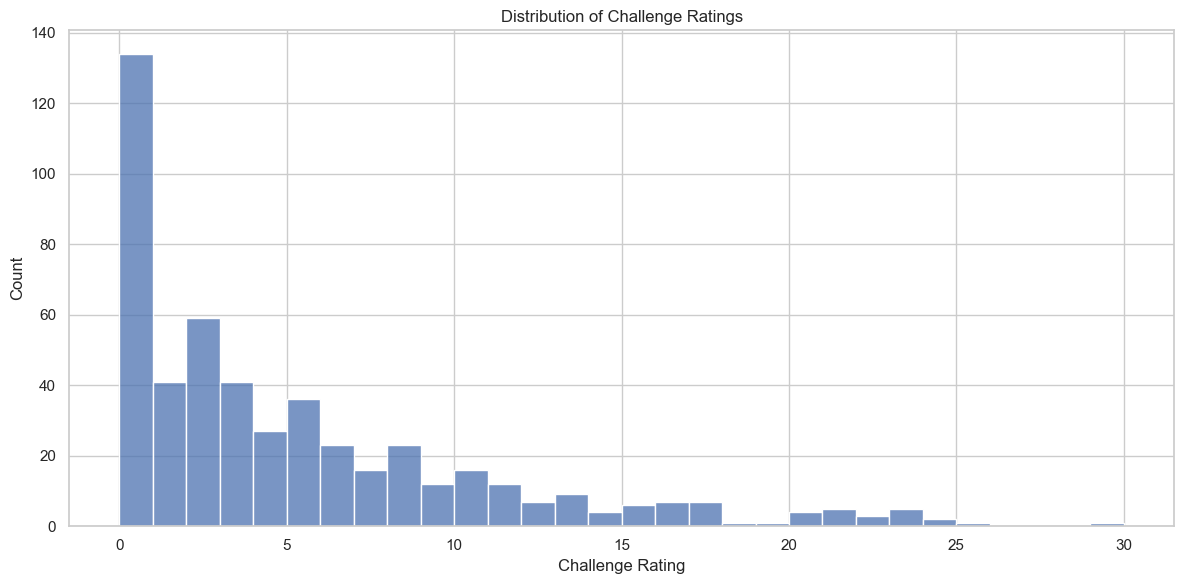

In [14]:
# Distribution of CRs
plt.figure(figsize=(12, 6))
sns.histplot(monster_df, x='cr', bins=30)
plt.title('Distribution of Challenge Ratings')
plt.xlabel('Challenge Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

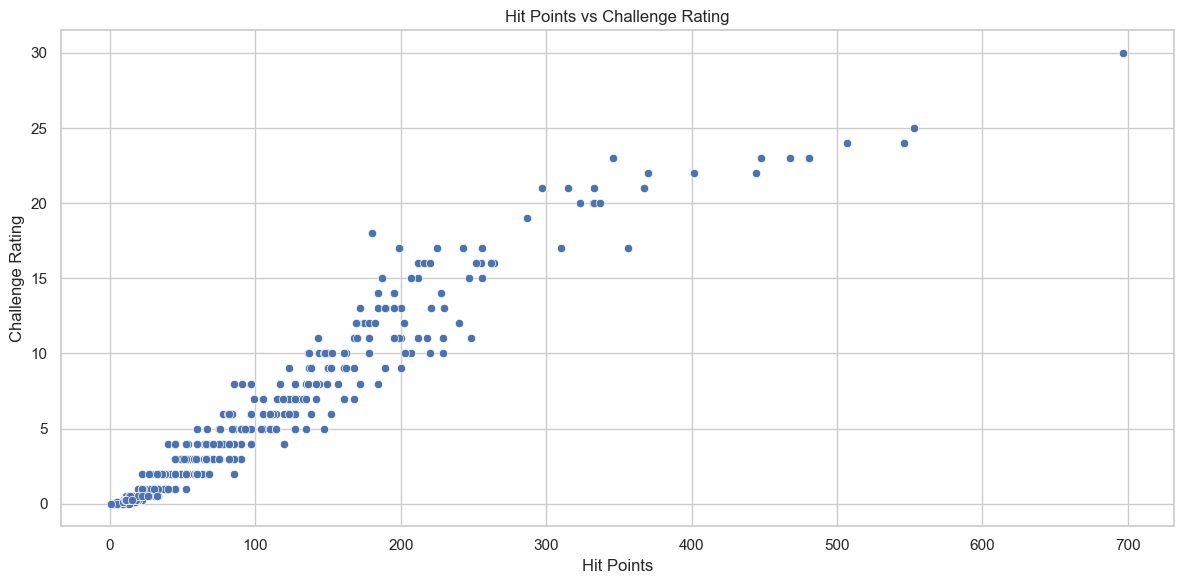

In [15]:
# Relationship between HP and CR
plt.figure(figsize=(12, 6))
sns.scatterplot(x='hp', y='cr', data=monster_df)
plt.title('Hit Points vs Challenge Rating')
plt.xlabel('Hit Points')
plt.ylabel('Challenge Rating')
plt.tight_layout()
plt.show()

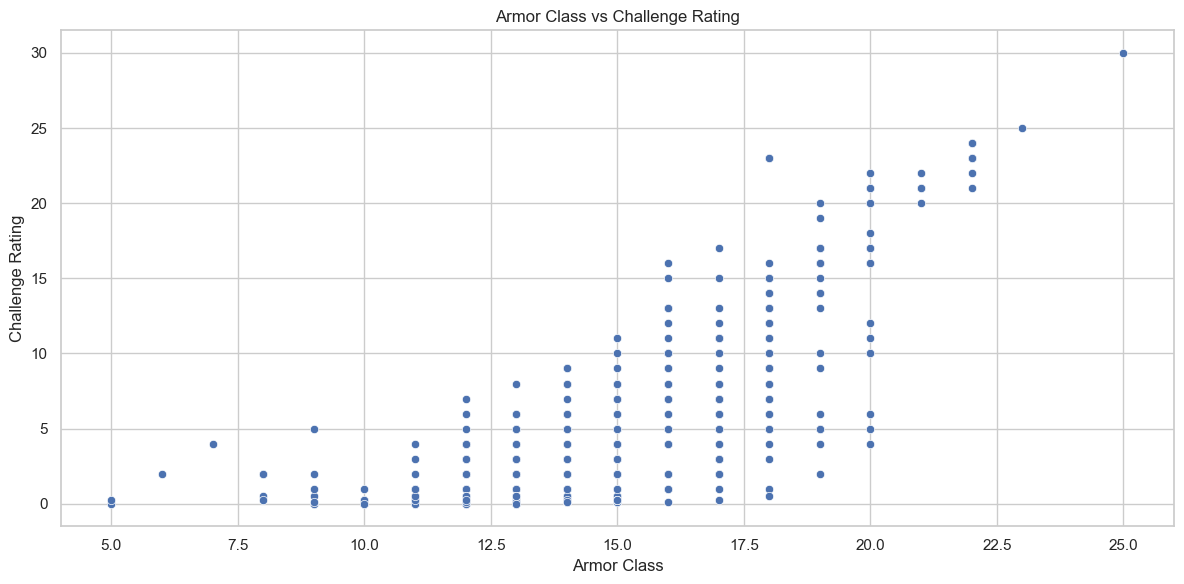

In [16]:
# Relationship between AC and CR
plt.figure(figsize=(12, 6))
sns.scatterplot(x='ac', y='cr', data=monster_df)
plt.title('Armor Class vs Challenge Rating')
plt.xlabel('Armor Class')
plt.ylabel('Challenge Rating')
plt.tight_layout()
plt.show()

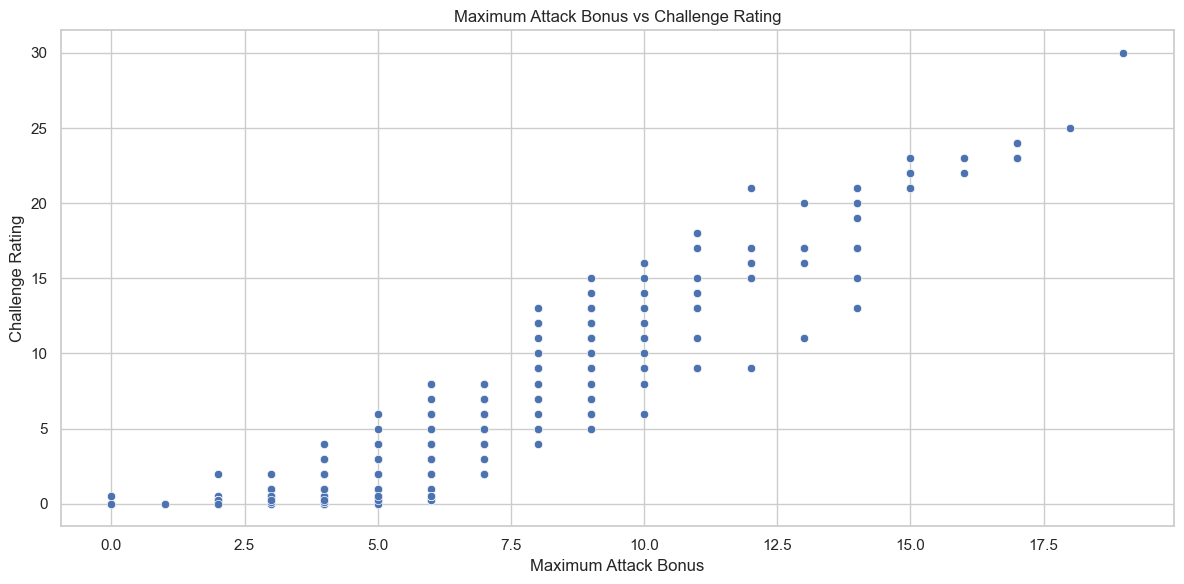

In [17]:
# Relationship between Attack Bonus and CR
plt.figure(figsize=(12, 6))
sns.scatterplot(x='max_attack_bonus', y='cr', data=monster_df)
plt.title('Maximum Attack Bonus vs Challenge Rating')
plt.xlabel('Maximum Attack Bonus')
plt.ylabel('Challenge Rating')
plt.tight_layout()
plt.show()

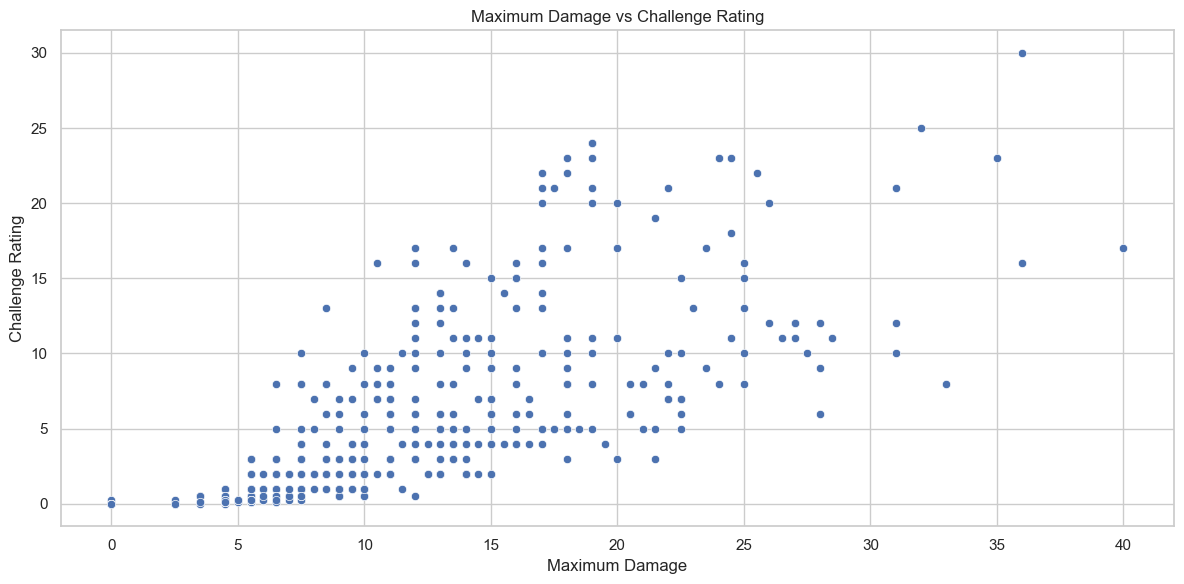

In [18]:
# Relationship between Damage and CR
plt.figure(figsize=(12, 6))
sns.scatterplot(x='max_damage', y='cr', data=monster_df)
plt.title('Maximum Damage vs Challenge Rating')
plt.xlabel('Maximum Damage')
plt.ylabel('Challenge Rating')
plt.tight_layout()
plt.show()

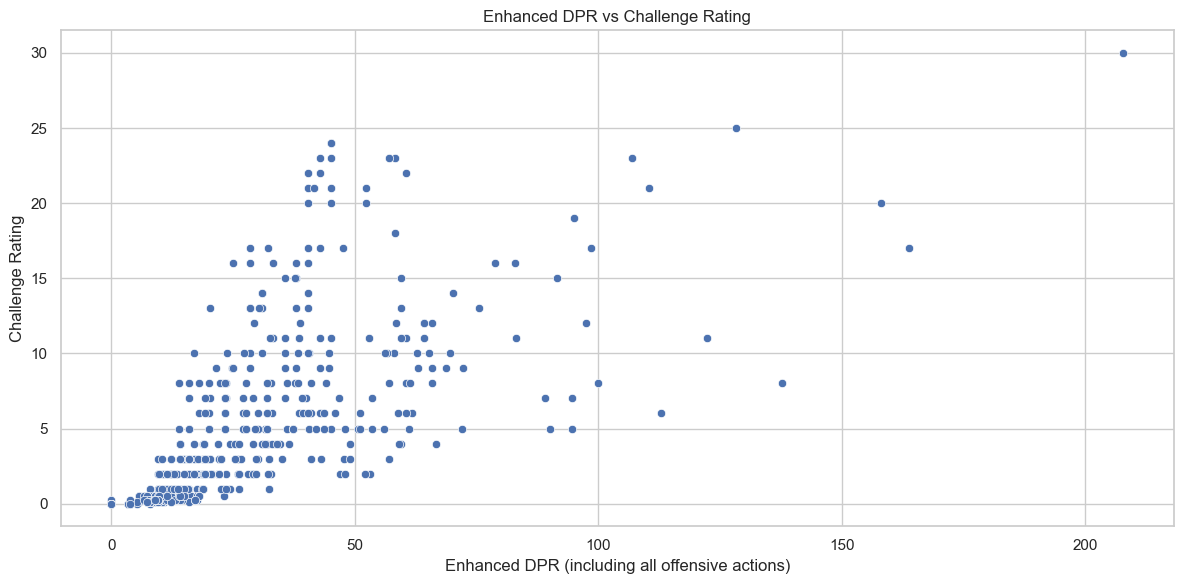

In [19]:
# Relationship between Enhanced DPR and CR
plt.figure(figsize=(12, 6))
sns.scatterplot(x='enhanced_dpr', y='cr', data=monster_df)
plt.title('Enhanced DPR vs Challenge Rating')
plt.xlabel('Enhanced DPR (including all offensive actions)')
plt.ylabel('Challenge Rating')
plt.tight_layout()
plt.show()

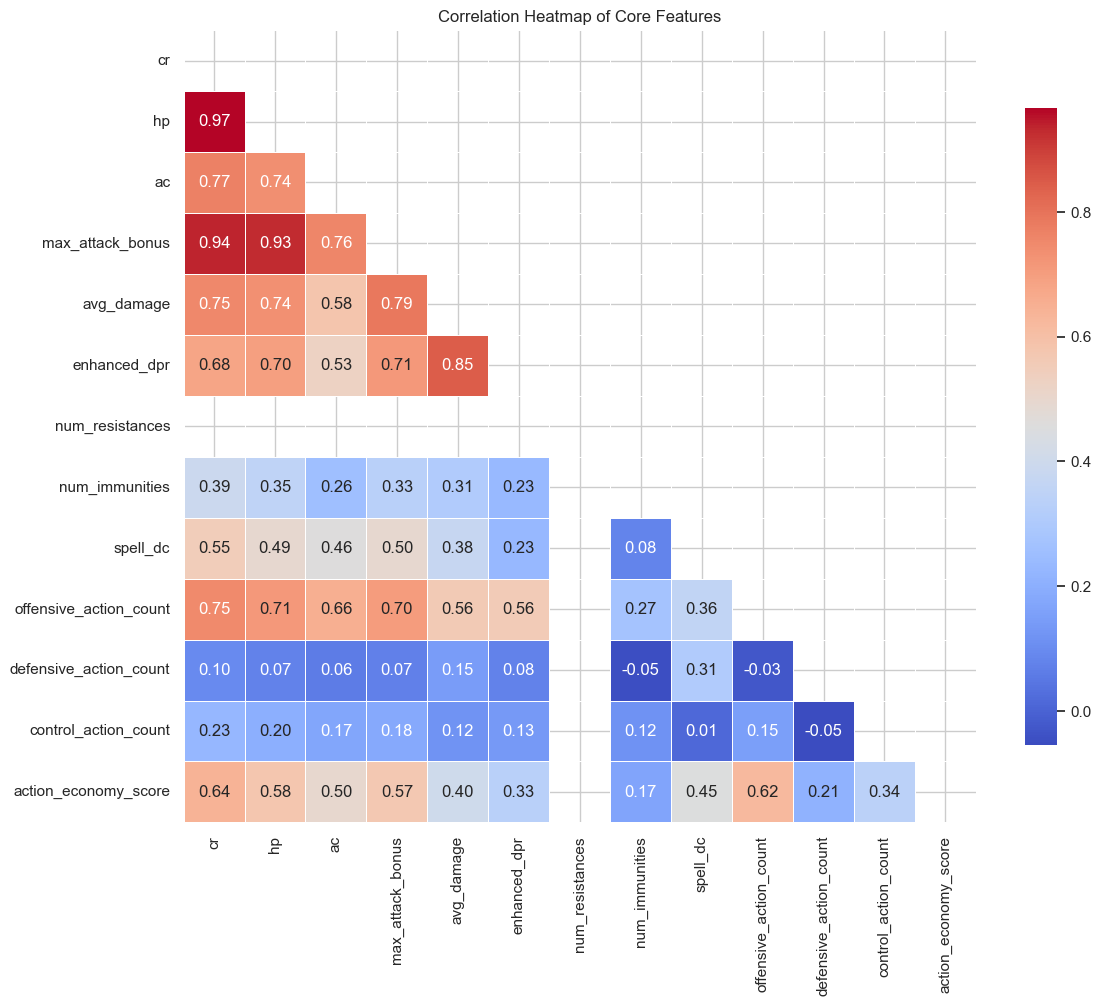

In [20]:
# Correlation heatmap of numerical features
core_features = ['cr', 'hp', 'ac', 'max_attack_bonus', 'avg_damage', 'enhanced_dpr',
                'num_resistances', 'num_immunities', 'spell_dc', 'offensive_action_count',
                'defensive_action_count', 'control_action_count', 'action_economy_score']

# Select only numerical columns that exist in the dataframe
core_features = [f for f in core_features if f in monster_df.columns]

corr_matrix = monster_df[core_features].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Core Features')
plt.tight_layout()
plt.show()

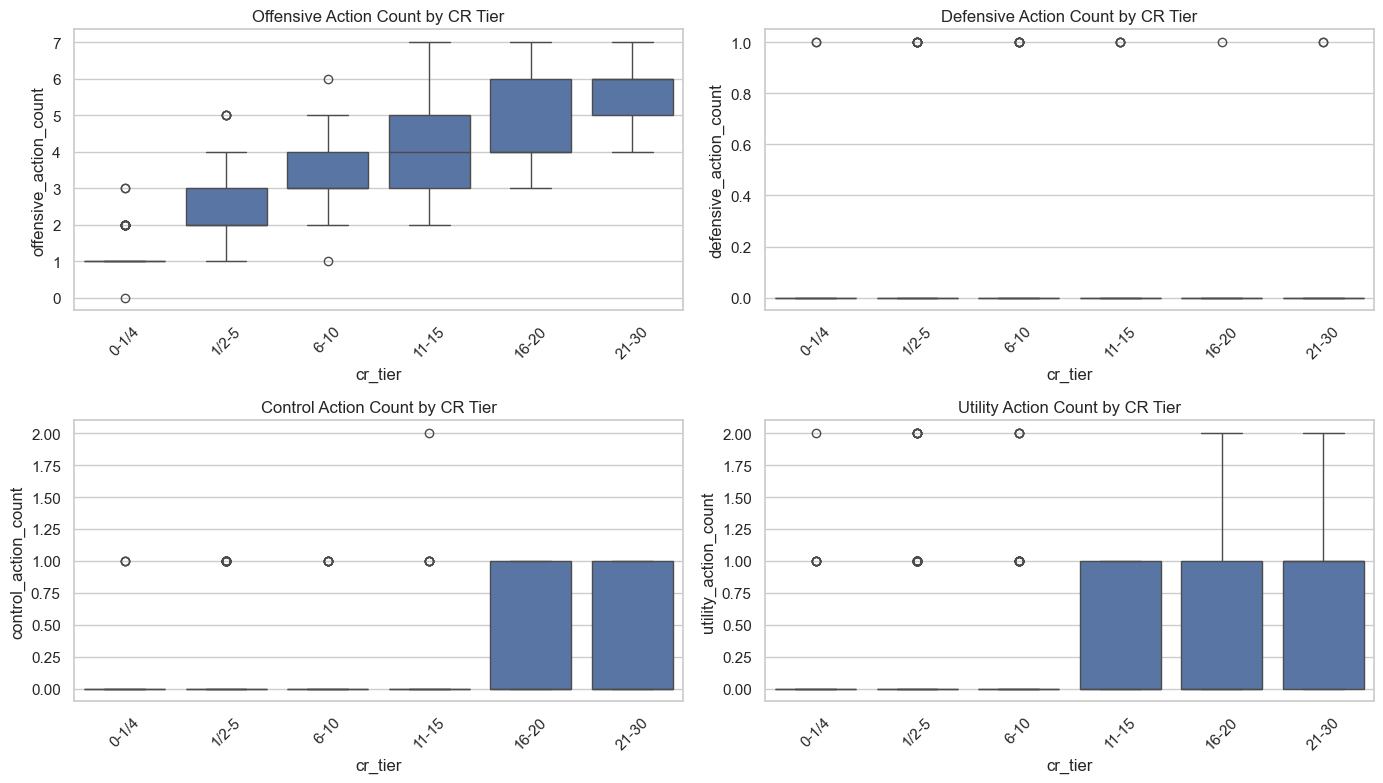

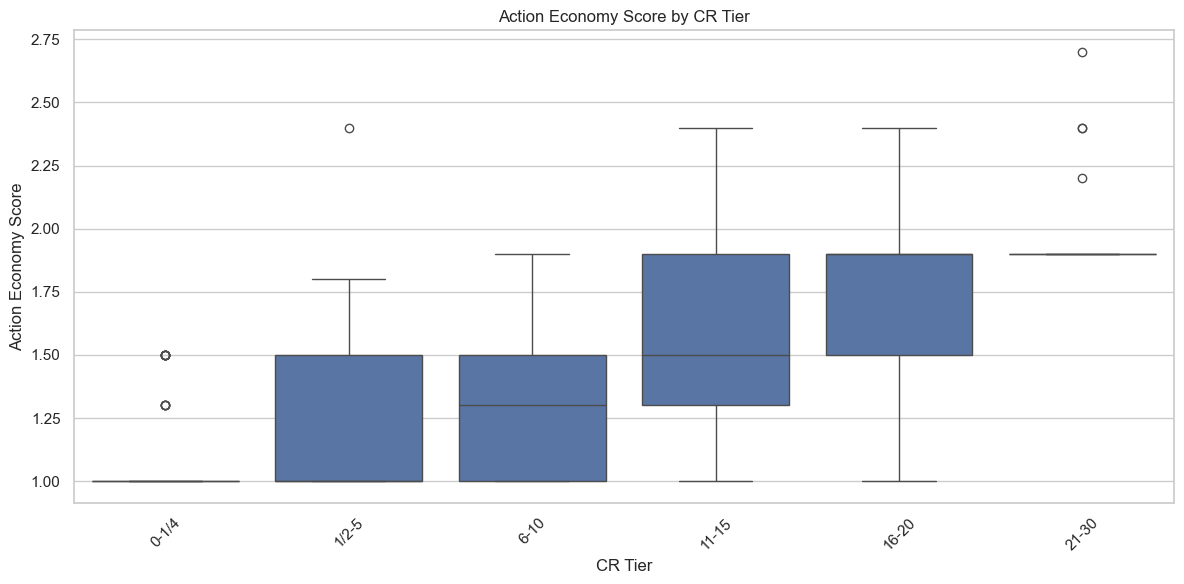

In [21]:
# Compare action types and CR
action_features = ['offensive_action_count', 'defensive_action_count', 
                    'control_action_count', 'utility_action_count']

# Check if these features exist in the dataframe
action_features = [f for f in action_features if f in monster_df.columns]

if action_features:
    # Plot action counts by CR tier
    plt.figure(figsize=(14, 8))
    
    for i, feature in enumerate(action_features):
        plt.subplot(2, 2, i+1)
        sns.boxplot(x='cr_tier', y=feature, data=monster_df)
        plt.title(f'{feature.replace("_", " ").title()} by CR Tier')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Plot action economy score by CR tier
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='cr_tier', y='action_economy_score', data=monster_df)
    plt.title('Action Economy Score by CR Tier')
    plt.xlabel('CR Tier')
    plt.ylabel('Action Economy Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# Spell levels by CR - doesn;t seem to be working
if 'highest_spell_level' in monster_df.columns and monster_df['has_spellcasting'].sum() > 0:
    spellcasters = monster_df[monster_df['has_spellcasting']]
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='cr', y='highest_spell_level', data=spellcasters)
    plt.title('Highest Spell Level vs CR')
    plt.xlabel('Challenge Rating')
    plt.ylabel('Highest Spell Level')
    plt.tight_layout()
    plt.show()

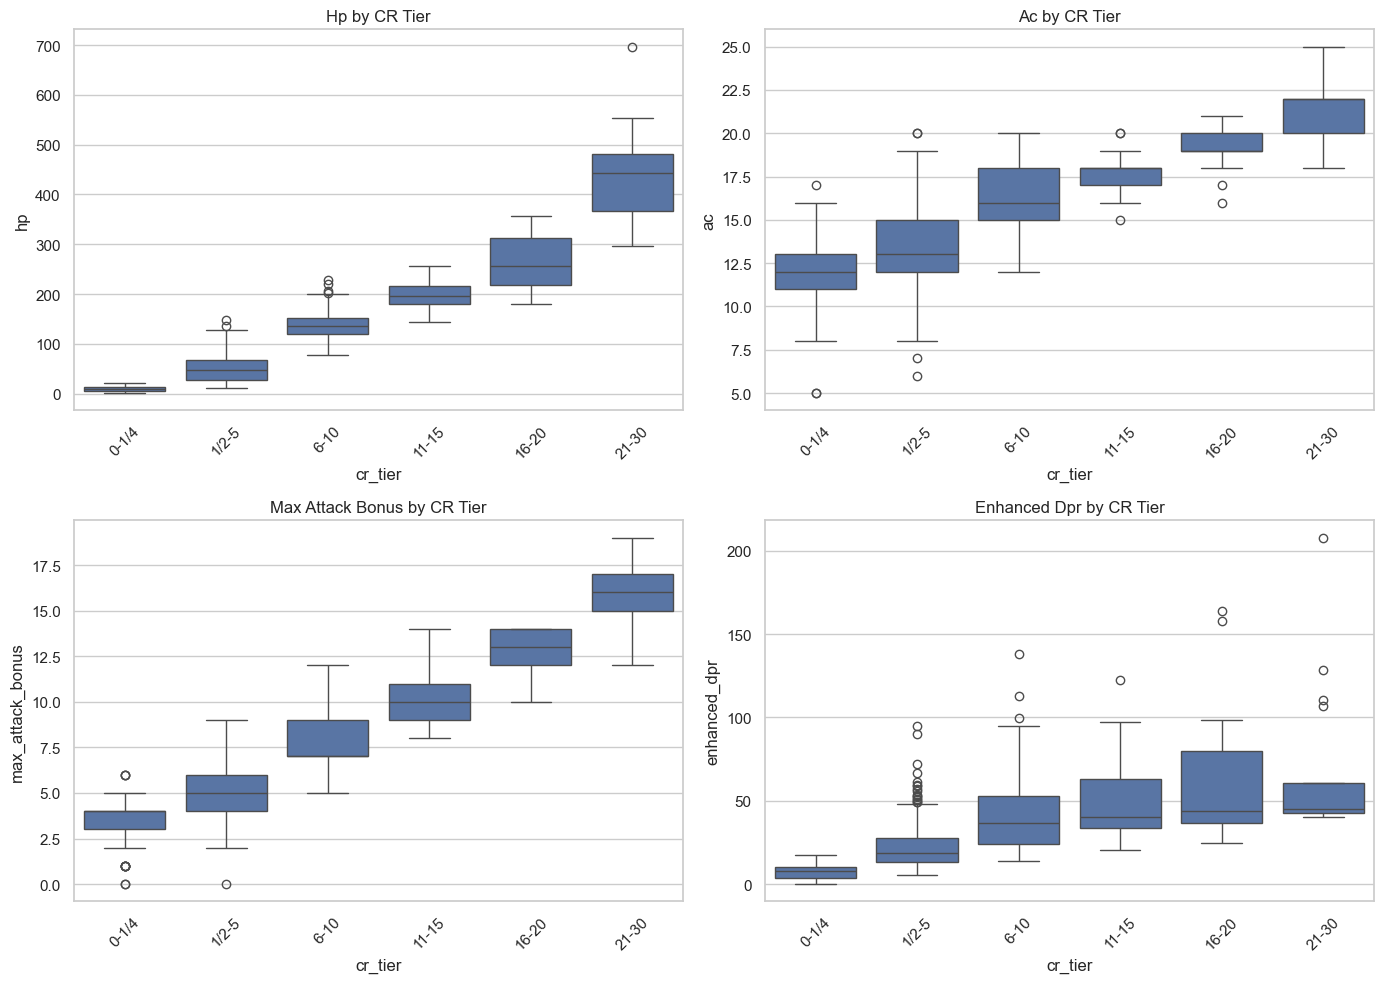

In [22]:
# Feature distributions by CR tier for key properties
core_features = ['hp', 'ac', 'max_attack_bonus', 'enhanced_dpr']

plt.figure(figsize=(14, 10))
for i, feature in enumerate(core_features):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='cr_tier', y=feature, data=monster_df)
    plt.title(f'{feature.replace("_", " ").title()} by CR Tier')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## 4. Feature Engineering

In [23]:
print(f'avg_damage: {monster_df["avg_damage"].mean()}; std_damage: {monster_df["avg_damage"].std()}')
print(f'z score for monster with 0 damage: {(0 - monster_df["avg_damage"].mean()) / monster_df["avg_damage"].std()}')

avg_damage: 10.654075546719682; std_damage: 6.242754229407347
z score for monster with 0 damage: -1.7066306241133444


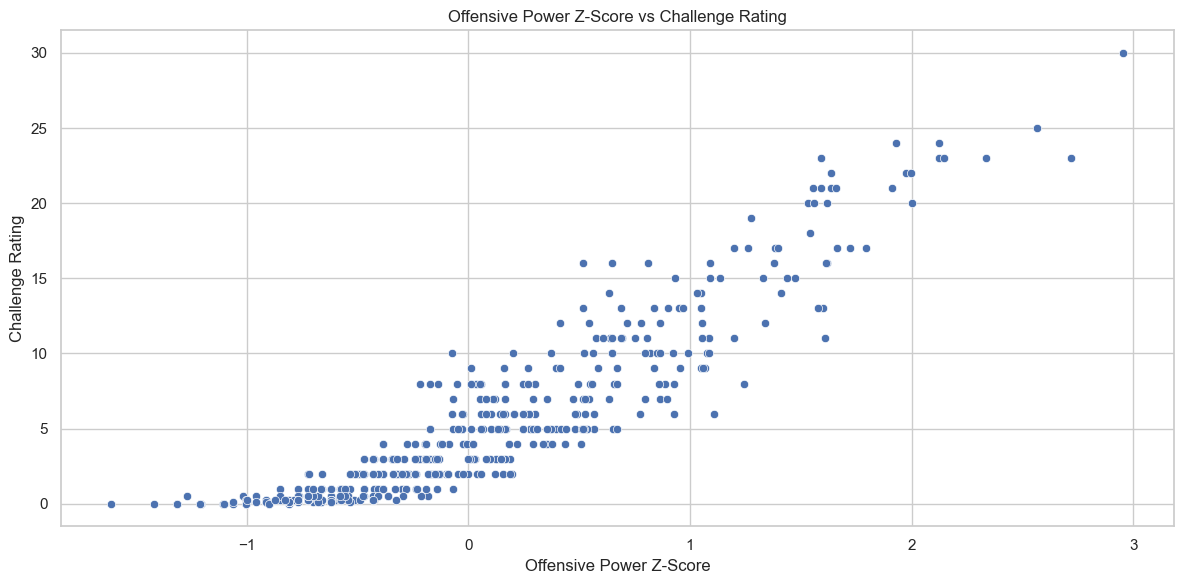

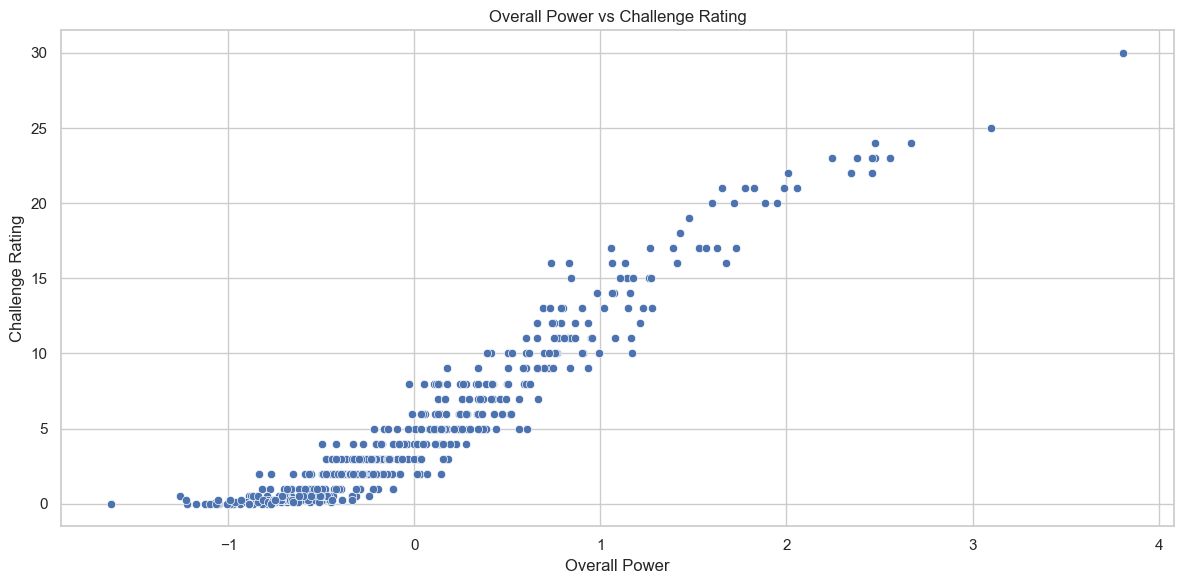

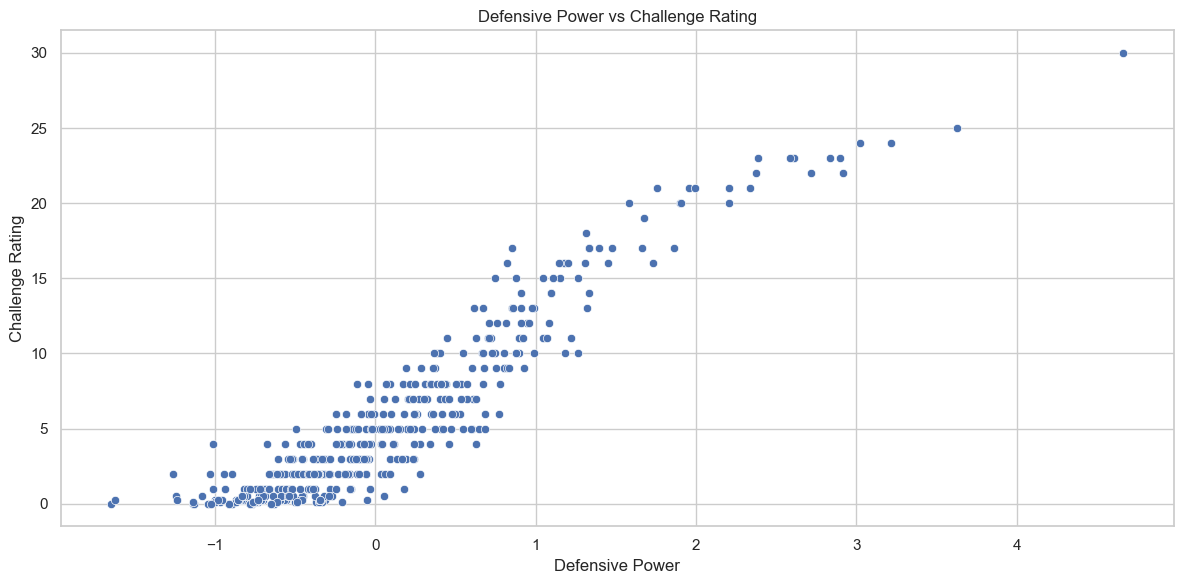

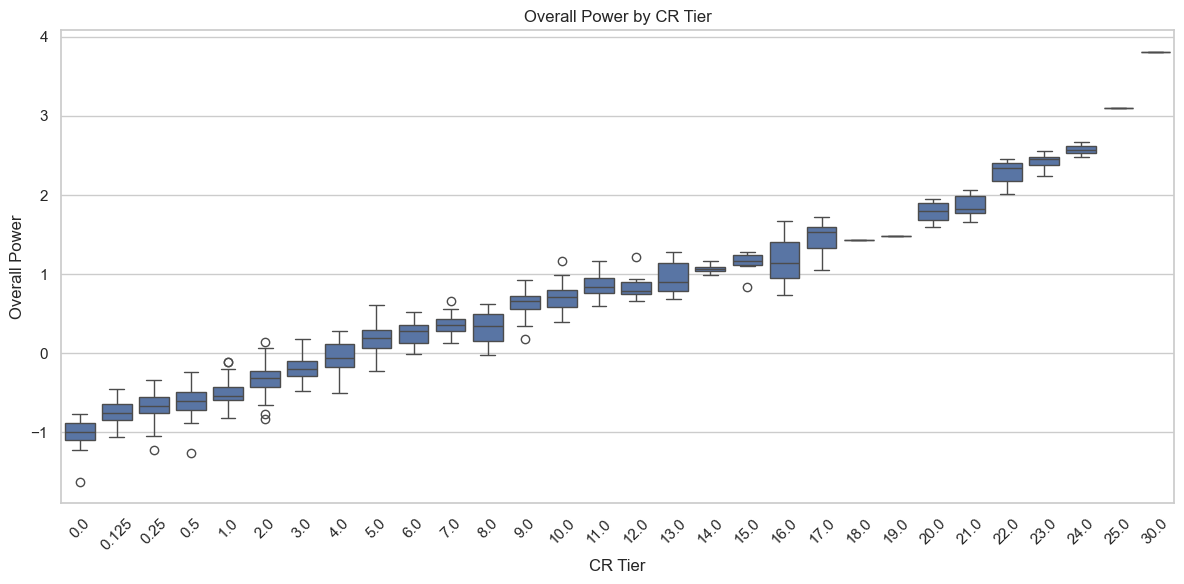

In [24]:
def engineer_features(monster_df):
    """
    Create derived features that might better predict CR
    """
    # Effective HP based on resistances and immunities
    monster_df['effective_hp'] = monster_df.apply(lambda row: row['hp'] * 
                                                (1 + (row['num_resistances'] * 0.05)) * 
                                                (1 + (row['num_immunities'] * 0.1)), axis=1)

    # get average of max attack bonus
    mean_attack_bonus = monster_df['max_attack_bonus'].mean()
    # Normalize attack bonus to z-score
    monster_df['attack_bonus_z'] = (monster_df['max_attack_bonus'] - mean_attack_bonus) / monster_df['max_attack_bonus'].std()
    # Normalize average damage to z-score 
    mean_damage = monster_df['avg_damage'].mean()
    monster_df['avg_damage_z'] = (monster_df['avg_damage'] - mean_damage) / monster_df['avg_damage'].std()
    # scale down average damage to 80% of its value to match its effectiveness at predicting CR
    monster_df['avg_damage_z'] *= 0.8
    # normalize offensive action count to z-score
    mean_offensive_action_count = monster_df['offensive_action_count'].mean()
    monster_df['offensive_action_count_z'] = (monster_df['offensive_action_count'] - mean_offensive_action_count) / monster_df['offensive_action_count'].std()
    # scale down offensive action count to 80% of its value to match its effectiveness at predicting CR
    monster_df['offensive_action_count_z'] *= 0.8

    # Calculate offensive power as avg damage z-score * attack bonus z-score * action economy z-score
    monster_df['offensive_power'] = (monster_df['avg_damage_z'] + monster_df['attack_bonus_z'] + monster_df['offensive_action_count_z']) / 3
    
    # Normalize effective HP to z-score
    mean_effective_hp = monster_df['effective_hp'].mean()
    monster_df['effective_hp_z'] = (monster_df['effective_hp'] - mean_effective_hp) / monster_df['effective_hp'].std()
    # Normalize AC to z-score
    mean_ac = monster_df['ac'].mean()
    monster_df['ac_z'] = (monster_df['ac'] - mean_ac) / monster_df['ac'].std()
    # AC is only 80% as effective as HP for predicting CR so scale it down
    monster_df['ac_z'] *= 0.8

    # Defensive power based on HP and AC
    monster_df['defensive_power'] = (monster_df['effective_hp_z'] + monster_df['ac_z']) / 2
    
    # Overall power
    monster_df['overall_power'] = (monster_df['offensive_power'] + monster_df['defensive_power']) / 2
    
    # Plot the new features
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='offensive_power', y='cr', data=monster_df)
    plt.title('Offensive Power Z-Score vs Challenge Rating')
    plt.xlabel('Offensive Power Z-Score')
    plt.ylabel('Challenge Rating')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='overall_power', y='cr', data=monster_df)
    plt.title('Overall Power vs Challenge Rating')
    plt.xlabel('Overall Power')
    plt.ylabel('Challenge Rating')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='defensive_power', y='cr', data=monster_df)
    plt.title('Defensive Power vs Challenge Rating')
    plt.xlabel('Defensive Power')
    plt.ylabel('Challenge Rating')
    plt.tight_layout()
    plt.show()

    # Plot overall power to CR group
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='cr', y='overall_power', data=monster_df)
    plt.title('Overall Power by CR Tier')
    plt.xlabel('CR Tier')
    plt.ylabel('Overall Power')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return monster_df

# Create engineered features
monster_df = engineer_features(monster_df)

In [25]:
# for each cr get the max, min, upper quartile, and lower quartile of the overall power
def lower_quartile(x):
    return x.quantile(0.25)

def upper_quartile(x):
    return x.quantile(0.75)
cr_stats_op = monster_df.groupby('cr')['overall_power'].agg(['min', 'max', lower_quartile, upper_quartile, 'mean', 'std', 'median', 'count']).reset_index()
cr_stats_of = monster_df.groupby('cr')['offensive_power'].agg(['min', 'max', lower_quartile, upper_quartile, 'mean', 'std', 'median', 'count']).reset_index()
cr_stats_df = monster_df.groupby('cr')['defensive_power'].agg(['min', 'max', lower_quartile, upper_quartile, 'mean', 'std', 'median', 'count']).reset_index()

# Merge the stats into one dataframe
cr_stats = pd.merge(cr_stats_df, cr_stats_of, on='cr', suffixes=('_defense', '_offense'))
cr_stats = pd.merge(cr_stats_op, cr_stats, on='cr')

# Save cr stats to json
cr_stats.to_json('cr_stats.json', orient='records', indent=2)

CRs with only a single example: [18.0, 19.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]
Average standard deviations used for range generation:
Overall: 0.1821, Defense: 0.2417, Offense: 0.2656

Monotonicity Check for High CRs:
      cr      mean  mean_defense  mean_offense
28  25.0  3.098872      3.630128      2.567616
29  26.0  3.241275      3.837265      2.645284
30  27.0  3.383678      4.044403      2.722952
31  28.0  3.526080      4.251540      2.800621
32  29.0  3.668483      4.458677      2.878289
33  30.0  4.084050      5.028438      3.354359
All values are monotonically increasing as expected.


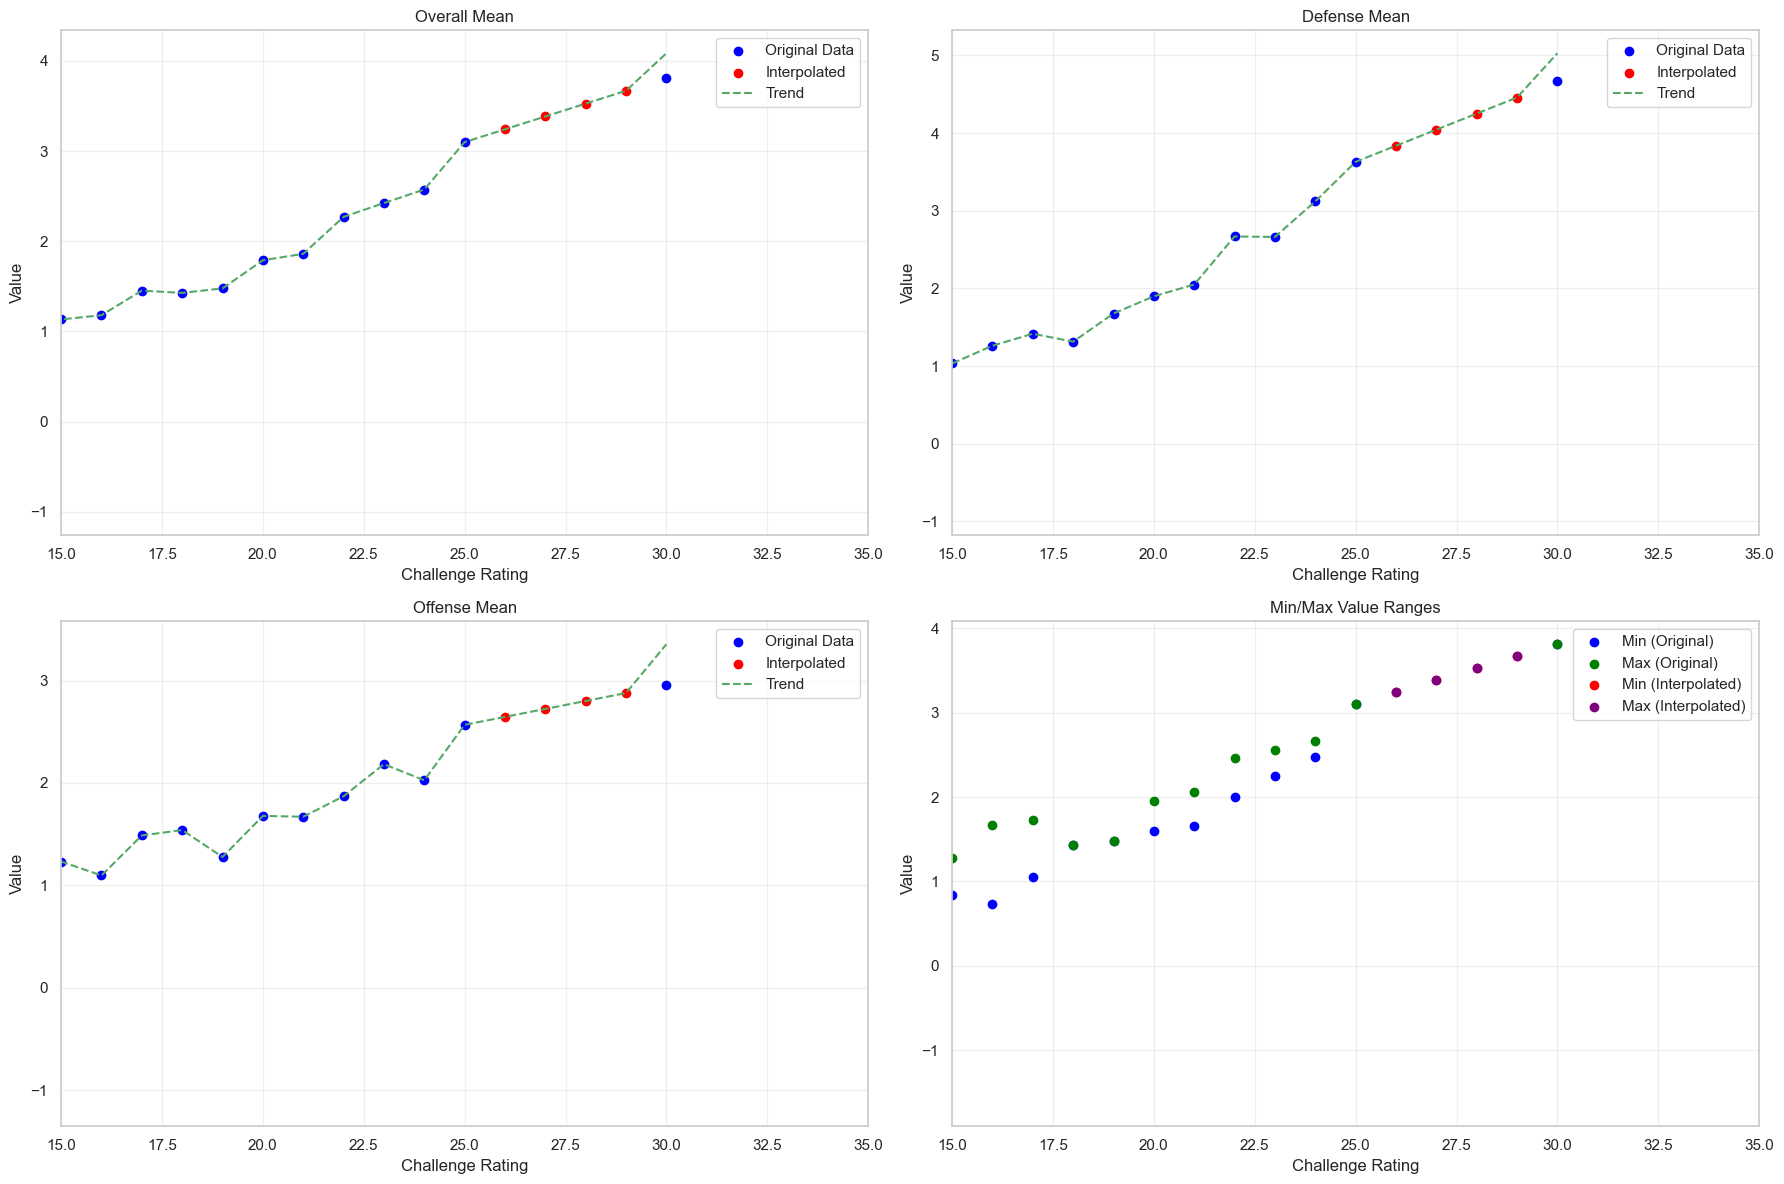


Interpolated and Original Data (Mean Values):
  cr     mean  mean_defense  mean_offense
20.0 1.788645      1.899153      1.678138
21.0 1.860143      2.050063      1.670222
22.0 2.269651      2.669282      1.870020
23.0 2.423074      2.662916      2.183232
24.0 2.573436      3.121007      2.025865
25.0 3.098872      3.630128      2.567616
26.0 3.241275      3.837265      2.645284
27.0 3.383678      4.044403      2.722952
28.0 3.526080      4.251540      2.800621
29.0 3.668483      4.458677      2.878289
30.0 4.084050      5.028438      3.354359

Results saved to 'cr_stats_with_interpolation.json'


In [28]:
import pandas as pd
import matplotlib.pyplot as plt

def interpolate_missing_crs(df, missing_crs=[26, 27, 28, 29]):
    """
    Interpolate values for missing CRs using linear interpolation
    between CR 25 and CR 30
    """
    # Verify CR 25 and CR 30 exist in the data
    if 25 not in df['cr'].values or 30 not in df['cr'].values:
        raise ValueError("CR 25 and CR 30 must exist in the data for interpolation")
    
    # Get CR 25 and CR 30 data
    cr25_data = df[df['cr'] == 25].iloc[0].to_dict()
    cr30_data = df[df['cr'] == 30].iloc[0].to_dict()
    
    # Initialize predictions dictionary
    predictions = {cr: {} for cr in missing_crs}
    
    # Interpolate for all columns except 'cr'
    for column in df.columns:
        if column == 'cr':
            continue
            
        # Handle standard deviation columns specially
        if column.endswith('std') or column == 'std' or column.endswith('std_defense') or column.endswith('std_offense'):
            # For standard deviations, use the average std from CRs 20-24 if available
            high_cr_stds = df[(df['cr'] >= 20) & (df['cr'] <= 24) & ~df[column].isnull()][column]
            
            if len(high_cr_stds) > 0:
                # Use average of available high CR standard deviations
                avg_std = high_cr_stds.mean()
                for cr in missing_crs:
                    predictions[cr][column] = avg_std
            else:
                # If no high CR stds available, use the average of all available stds
                all_stds = df[~df[column].isnull()][column]
                if len(all_stds) > 0:
                    avg_std = all_stds.mean()
                    for cr in missing_crs:
                        predictions[cr][column] = avg_std
                else:
                    # If no stds available at all, use a default value
                    for cr in missing_crs:
                        predictions[cr][column] = 0.2  # Default reasonable std value
            continue
        
        # Skip if either value is None/null for other columns
        if pd.isnull(cr25_data[column]) or pd.isnull(cr30_data[column]):
            continue
            
        # Linear interpolation between CR 25 and CR 30
        cr25_val = cr25_data[column]
        cr30_val = cr30_data[column]
        
        for cr in missing_crs:
            # Calculate the interpolation ratio (0 at CR 25, 1 at CR 30)
            ratio = (cr - 25) / (30 - 25)
            
            # Calculate interpolated value
            interpolated_val = cr25_val + ratio * (cr30_val - cr25_val)
            
            # For count columns, round to nearest integer
            if column.startswith('count'):
                interpolated_val = max(1, round(interpolated_val))
                
            predictions[cr][column] = interpolated_val
    
    return predictions

def create_result_dataframe(df, predictions):
    """Create a DataFrame with original and predicted data"""
    result_df = df.copy()
    
    # Add predictions
    for cr in predictions:
        row = {'cr': cr}
        row.update(predictions[cr])
        result_df = pd.concat([result_df, pd.DataFrame([row])], ignore_index=True)
    
    # Sort by CR
    result_df = result_df.sort_values('cr').reset_index(drop=True)
    
    return result_df

def plot_results(df, result_df, missing_crs, predictions):
    """Plot the results of the interpolation"""
    plt.figure(figsize=(18, 12))
    
    # Plot overall, defense, and offense means
    stats = ['mean', 'mean_defense', 'mean_offense']
    titles = ['Overall Mean', 'Defense Mean', 'Offense Mean']
    
    for i, (stat, title) in enumerate(zip(stats, titles)):
        plt.subplot(2, 2, i+1)
        
        # Original data
        plt.scatter(df['cr'], df[stat], color='blue', label='Original Data')
        
        # Predicted data
        pred_crs = [cr for cr in missing_crs if stat in predictions[cr]]
        pred_vals = [predictions[cr][stat] for cr in pred_crs]
        plt.scatter(pred_crs, pred_vals, color='red', label='Interpolated')
        
        # Trend line for all data
        plt.plot(result_df['cr'], result_df[stat], 'g--', label='Trend')
        
        # Focus on high CR range
        plt.xlim(15, 35)
        
        plt.title(title)
        plt.xlabel('Challenge Rating')
        plt.ylabel('Value')
        plt.grid(True, alpha=0.3)
        plt.legend()
    
    # Plot min/max ranges for high CRs
    plt.subplot(2, 2, 4)
    plt.scatter(df['cr'], df['min'], color='blue', label='Min (Original)')
    plt.scatter(df['cr'], df['max'], color='green', label='Max (Original)')
    
    pred_crs = missing_crs
    pred_mins = [predictions[cr]['min'] for cr in pred_crs]
    pred_maxs = [predictions[cr]['max'] for cr in pred_crs]
    
    plt.scatter(pred_crs, pred_mins, color='red', label='Min (Interpolated)')
    plt.scatter(pred_crs, pred_maxs, color='purple', label='Max (Interpolated)')
    
    # Focus on high CR range
    plt.xlim(15, 35)
    
    plt.title('Min/Max Value Ranges')
    plt.xlabel('Challenge Rating')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('cr_interpolation.png')
    plt.show()

def verify_monotonicity(result_df):
    """Verify values are monotonically increasing for high CRs"""
    high_crs = [25, 26, 27, 28, 29, 30]
    high_cr_df = result_df[result_df['cr'].isin(high_crs)].sort_values('cr')
    
    print("\nMonotonicity Check for High CRs:")
    print(high_cr_df[['cr', 'mean', 'mean_defense', 'mean_offense']])
    
    # Check if values are increasing
    is_monotonic = True
    for stat in ['mean', 'mean_defense', 'mean_offense']:
        values = high_cr_df[stat].values
        if not all(values[i] <= values[i+1] for i in range(len(values)-1)):
            is_monotonic = False
            print(f"Warning: {stat} is not monotonically increasing!")
    
    if is_monotonic:
        print("All values are monotonically increasing as expected.")
    
    return is_monotonic

def generate_statistical_ranges(result_df):
    """
    Generate min, max, and quartile ranges for CRs with single examples
    using average standard deviations from well-represented CRs.
    Special handling for CR 30 as it represents the upper limit.
    """
    # Identify CRs with only a single example
    single_example_crs = result_df[result_df['count'] == 1]['cr'].tolist()
    print(f"CRs with only a single example: {single_example_crs}")
    
    # Calculate average standard deviations from CRs with multiple examples
    multi_example_df = result_df[result_df['count'] > 2]
    
    # Get average standard deviations for overall, defense, and offense
    if len(multi_example_df) > 0:
        avg_std = multi_example_df['std'].mean() if not multi_example_df['std'].isnull().all() else 0.2
        avg_std_defense = multi_example_df['std_defense'].mean() if not multi_example_df['std_defense'].isnull().all() else 0.25
        avg_std_offense = multi_example_df['std_offense'].mean() if not multi_example_df['std_offense'].isnull().all() else 0.25
    else:
        # Default values if no multi-example CRs
        avg_std = 0.2
        avg_std_defense = 0.25
        avg_std_offense = 0.25
    
    print(f"Average standard deviations used for range generation:")
    print(f"Overall: {avg_std:.4f}, Defense: {avg_std_defense:.4f}, Offense: {avg_std_offense:.4f}")
    
    # For each single-example CR
    for cr in single_example_crs:
        row_idx = result_df[result_df['cr'] == cr].index[0]
        
        # Special handling for CR 30
        if cr == 30:
            # For CR 30, use existing value as minimum and build distribution upward
            
            # Overall stats
            if pd.isnull(result_df.at[row_idx, 'std']):
                result_df.at[row_idx, 'std'] = avg_std
            
            # Use existing value as the minimum
            min_val = result_df.at[row_idx, 'mean']  # Use current value as minimum
            result_df.at[row_idx, 'min'] = min_val
            
            # Calculate plausible median by adding std
            median_val = min_val + avg_std
            result_df.at[row_idx, 'median'] = median_val
            
            # Calculate other statistics based on this upward distribution
            result_df.at[row_idx, 'lower_quartile'] = min_val + (0.33 * avg_std)
            result_df.at[row_idx, 'upper_quartile'] = median_val + (0.67 * avg_std)
            result_df.at[row_idx, 'max'] = median_val + (2 * avg_std)
            
            # Update mean to be between min and max
            result_df.at[row_idx, 'mean'] = (min_val + result_df.at[row_idx, 'max']) / 2
            
            # Defense stats
            if pd.isnull(result_df.at[row_idx, 'std_defense']):
                result_df.at[row_idx, 'std_defense'] = avg_std_defense
                
            min_defense = result_df.at[row_idx, 'mean_defense']  # Use current value as minimum
            result_df.at[row_idx, 'min_defense'] = min_defense
            
            # Calculate plausible median
            median_defense = min_defense + avg_std_defense
            result_df.at[row_idx, 'median_defense'] = median_defense
            
            # Calculate other statistics
            result_df.at[row_idx, 'lower_quartile_defense'] = min_defense + (0.33 * avg_std_defense)
            result_df.at[row_idx, 'upper_quartile_defense'] = median_defense + (0.67 * avg_std_defense)
            result_df.at[row_idx, 'max_defense'] = median_defense + (2 * avg_std_defense)
            
            # Update mean
            result_df.at[row_idx, 'mean_defense'] = (min_defense + result_df.at[row_idx, 'max_defense']) / 2
            
            # Offense stats
            if pd.isnull(result_df.at[row_idx, 'std_offense']):
                result_df.at[row_idx, 'std_offense'] = avg_std_offense
                
            min_offense = result_df.at[row_idx, 'mean_offense']  # Use current value as minimum
            result_df.at[row_idx, 'min_offense'] = min_offense
            
            # Calculate plausible median
            median_offense = min_offense + avg_std_offense
            result_df.at[row_idx, 'median_offense'] = median_offense
            
            # Calculate other statistics
            result_df.at[row_idx, 'lower_quartile_offense'] = min_offense + (0.33 * avg_std_offense)
            result_df.at[row_idx, 'upper_quartile_offense'] = median_offense + (0.67 * avg_std_offense)
            result_df.at[row_idx, 'max_offense'] = median_offense + (2 * avg_std_offense)
            
            # Update mean
            result_df.at[row_idx, 'mean_offense'] = (min_offense + result_df.at[row_idx, 'max_offense']) / 2
        
        else:
            # Normal handling for other single-example CRs
            # Get the mean values
            mean_val = result_df.at[row_idx, 'mean']
            mean_defense = result_df.at[row_idx, 'mean_defense']
            mean_offense = result_df.at[row_idx, 'mean_offense']
            
            # Generate ranges based on mean and average standard deviation
            
            # Overall stats
            if pd.isnull(result_df.at[row_idx, 'std']):
                result_df.at[row_idx, 'std'] = avg_std
            
            result_df.at[row_idx, 'min'] = mean_val - 2 * avg_std
            result_df.at[row_idx, 'max'] = mean_val + 2 * avg_std
            result_df.at[row_idx, 'lower_quartile'] = mean_val - 0.67 * avg_std
            result_df.at[row_idx, 'upper_quartile'] = mean_val + 0.67 * avg_std
            result_df.at[row_idx, 'median'] = mean_val
            
            # Defense stats
            if pd.isnull(result_df.at[row_idx, 'std_defense']):
                result_df.at[row_idx, 'std_defense'] = avg_std_defense
                
            result_df.at[row_idx, 'min_defense'] = mean_defense - 2 * avg_std_defense
            result_df.at[row_idx, 'max_defense'] = mean_defense + 2 * avg_std_defense
            result_df.at[row_idx, 'lower_quartile_defense'] = mean_defense - 0.67 * avg_std_defense
            result_df.at[row_idx, 'upper_quartile_defense'] = mean_defense + 0.67 * avg_std_defense
            result_df.at[row_idx, 'median_defense'] = mean_defense
            
            # Offense stats
            if pd.isnull(result_df.at[row_idx, 'std_offense']):
                result_df.at[row_idx, 'std_offense'] = avg_std_offense
                
            result_df.at[row_idx, 'min_offense'] = mean_offense - 2 * avg_std_offense
            result_df.at[row_idx, 'max_offense'] = mean_offense + 2 * avg_std_offense
            result_df.at[row_idx, 'lower_quartile_offense'] = mean_offense - 0.67 * avg_std_offense
            result_df.at[row_idx, 'upper_quartile_offense'] = mean_offense + 0.67 * avg_std_offense
            result_df.at[row_idx, 'median_offense'] = mean_offense
    
    return result_df

# Load data
df = cr_stats.copy()

# Define missing CRs
missing_crs = [26, 27, 28, 29]

# Use linear interpolation for missing CRs
predictions = interpolate_missing_crs(df, missing_crs)

# Create result DataFrame
result_df = create_result_dataframe(df, predictions)

# Generate statistical ranges for single-example CRs
result_df = generate_statistical_ranges(result_df)

# Verify monotonicity
verify_monotonicity(result_df)

# Plot results
plot_results(df, result_df, missing_crs, predictions)

# Print summary
print("\nInterpolated and Original Data (Mean Values):")
high_crs = list(range(20, 31))
print(result_df[result_df['cr'].isin(high_crs)][['cr', 'mean', 'mean_defense', 'mean_offense']].sort_values('cr').to_string(index=False))

# Save results
output_file='cr_stats_with_interpolation.json'
result_df.to_json(output_file, orient='records', indent=2)
print(f"\nResults saved to '{output_file}'")

    

## 5. Statistical Analysis & Modeling

Random Forest MSE: 0.5664
Random Forest R²: 0.9807


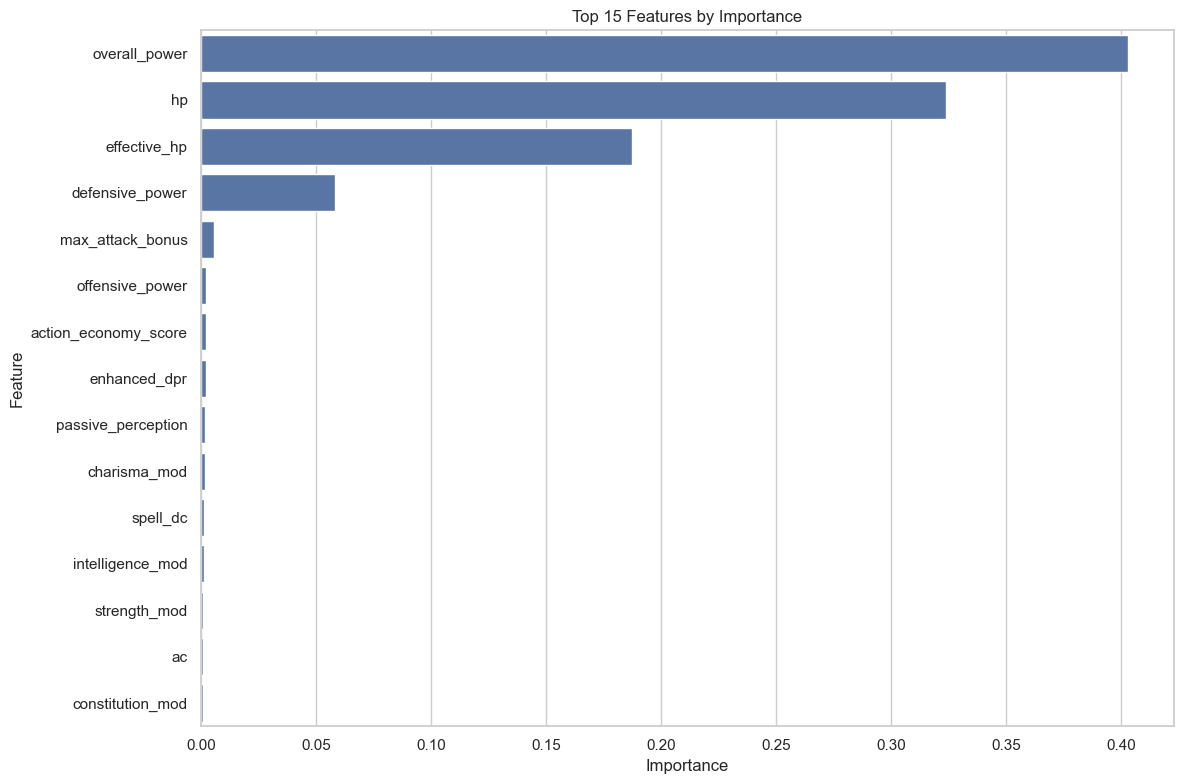

Linear Regression MSE: 0.9762
Linear Regression R²: 0.9668

Linear model coefficients:


,Feature,Coefficient
4,offensive_power,1.460347
8,has_legendary,1.277142
6,overall_power,0.734267
26,action_economy_score,0.550172
17,num_immunities,0.539979
25,control_action_count,0.272266
20,num_traits,0.156142
7,max_attack_bonus,0.144707
14,wisdom_mod,0.140007
22,spell_dc,0.139312


In [ ]:
from typing import Tuple


def build_cr_prediction_models(monster_df) -> Tuple[RandomForestRegressor, LinearRegression]:
    """
    Build models to predict CR based on monster statistics
    """
    # Prepare features for modeling
    feature_cols = [
        'ac', 'hp', 'effective_hp', 'enhanced_dpr', 'offensive_power', 'defensive_power',
        'overall_power', 'max_attack_bonus', 'has_legendary', 'has_lair', 'strength_mod',
        'dexterity_mod', 'constitution_mod', 'intelligence_mod', 'wisdom_mod', 'charisma_mod',
        'num_resistances', 'num_immunities', 'num_condition_immunities',
        'passive_perception', 'num_traits', 'has_spellcasting', 'spell_dc',
        'offensive_action_count', 'defensive_action_count', 'control_action_count',
        'action_economy_score'
    ]

    # Make sure all feature columns exist in the dataframe
    feature_cols = [f for f in feature_cols if f in monster_df.columns]
    
    # Split into training and testing sets
    X = monster_df[feature_cols]
    y = monster_df['cr']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train a Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    rf_mse = mean_squared_error(y_test, y_pred)
    rf_r2 = r2_score(y_test, y_pred)

    print(f"Random Forest MSE: {rf_mse:.4f}")
    print(f"Random Forest R²: {rf_r2:.4f}")

    # Feature importance
    importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance.head(15))
    plt.title('Top 15 Features by Importance')
    plt.tight_layout()
    plt.show()

    # Linear regression for comparison
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)
    lr_mse = mean_squared_error(y_test, lr_pred)
    lr_r2 = r2_score(y_test, lr_pred)

    print(f"Linear Regression MSE: {lr_mse:.4f}")
    print(f"Linear Regression R²: {lr_r2:.4f}")

    # Extract coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': lr_model.coef_
    }).sort_values(by='Coefficient', ascending=False)

    print("\nLinear model coefficients:")
    display(coef_df.head(10))
    
    # Save the models
    joblib.dump(rf_model, 'cr_prediction_rf_model.pkl')
    joblib.dump(lr_model, 'cr_prediction_lr_model.pkl')
    
    return rf_model, lr_model

# Build prediction models
rf_model, lr_model = build_cr_prediction_models(monster_df)
# Load the models for future use

## 6. Formula Derivation

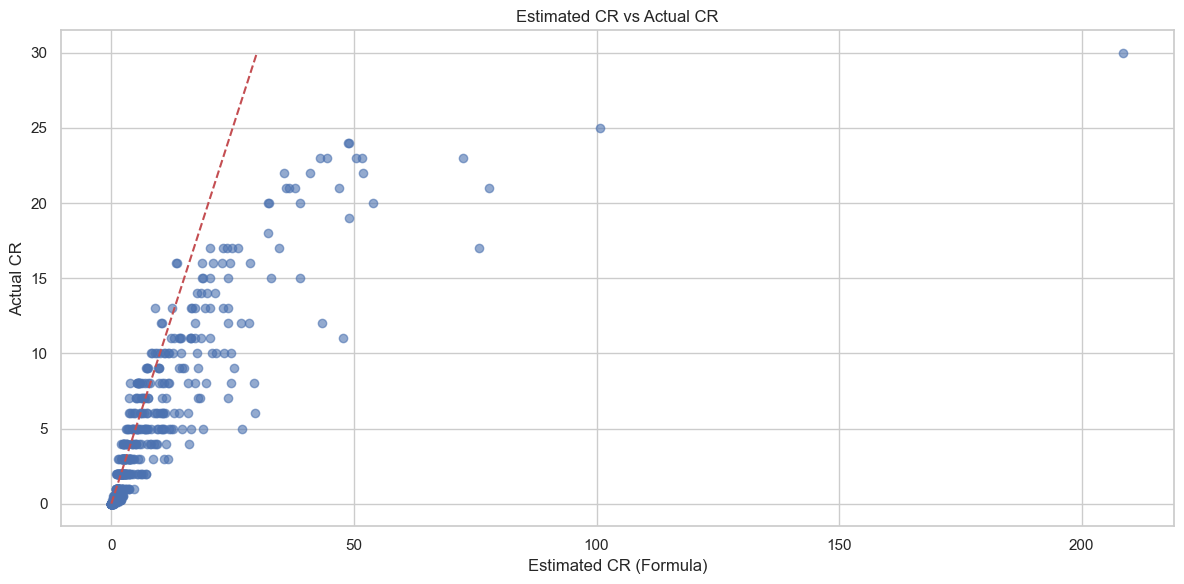

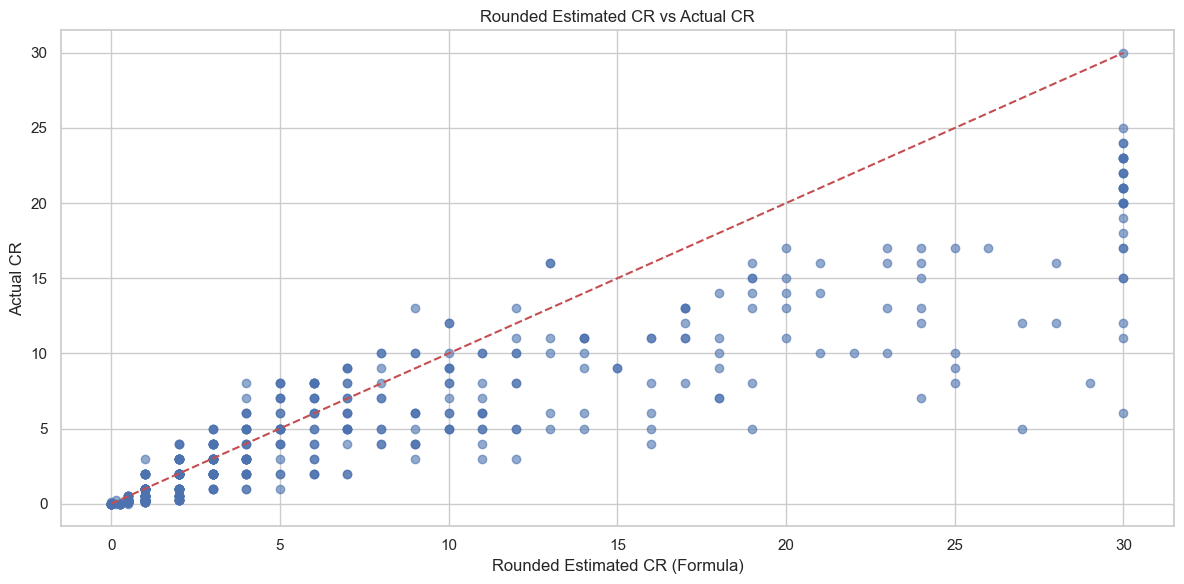

Exact CR match: 20.3%
Within 1 CR: 56.9%
Correlation between estimated and actual CR: 0.8037


In [ ]:
def derive_cr_formula(monster_df):
    """
    Derive a simpler formula for CR calculation
    """
    # Calculate basic offensive CR and defensive CR (similar to 5e DMG method but updated)
    def estimate_effective_cr(row):
        """
        Estimate a monster's CR based on enhanced offensive and defensive metrics
        """
        # get average of max attack bonus
        mean_attack_bonus = monster_df['max_attack_bonus'].mean()
        # Normalize attack bonus to z-score
        attack_bonus_z = (monster_df['max_attack_bonus'] - mean_attack_bonus) / monster_df['max_attack_bonus'].std()
        # Normalize average damage to z-score 
        mean_damage = monster_df['avg_damage'].mean()
        avg_damage_z = (monster_df['avg_damage'] - mean_damage) / monster_df['avg_damage'].std()
        # scale down average damage to 80% of its value to match its effectiveness at predicting CR
        avg_damage_z *= 0.8
        # normalize offensive action count to z-score
        mean_offensive_action_count = monster_df['offensive_action_count'].mean()
        offensive_action_count_z = (monster_df['offensive_action_count'] - mean_offensive_action_count) / monster_df['offensive_action_count'].std()
        # scale down offensive action count to 80% of its value to match its effectiveness at predicting CR
        offensive_action_count_z *= 0.8

        # Calculate offensive power as avg damage z-score * attack bonus z-score * action economy z-score
        offensive_power = (monster_df['avg_damage_z'] + monster_df['attack_bonus_z'] + monster_df['offensive_action_count_z']) / 3

        # Simplified formula derived from data analysis
        if offensive_power <= 0:
            offensive_cr = 0
        elif offensive_power <= 5:
            offensive_cr = offensive_power / 6
        elif offensive_power <= 10:
            offensive_cr = offensive_power / 5 - 0.2
        elif offensive_power <= 20:
            offensive_cr = offensive_power / 4 - 0.7
        elif offensive_power <= 40:
            offensive_cr = offensive_power / 3 - 3
        else:
            offensive_cr = offensive_power / 2.5 - 6
        
        # Normalize effective HP to z-score
        mean_effective_hp = monster_df['effective_hp'].mean()
        effective_hp_z = (monster_df['effective_hp'] - mean_effective_hp) / monster_df['effective_hp'].std()
        # Normalize AC to z-score
        mean_ac = monster_df['ac'].mean()
        ac_z = (monster_df['ac'] - mean_ac) / monster_df['ac'].std()
        # AC is only 80% as effective as HP for predicting CR so scale it down
        ac_z *= 0.8

        # Defensive power based on HP and AC
        defensive_power = (monster_df['effective_hp_z'] + monster_df['ac_z']) / 2
        
        # Overall power
        overall_power = (monster_df['offensive_power'] + monster_df['defensive_power']) / 2
        
        # Calculate defensive CR based on HP benchmarks from the DMG
        # Simplified formula derived from data analysis
        if defensive_power <= 0:
            defensive_cr = 0
        elif defensive_power <= 35:
            defensive_cr = defensive_power / 50
        elif defensive_power <= 70:
            defensive_cr = defensive_power / 35 - 0.5
        elif defensive_power <= 140:
            defensive_cr = defensive_power / 25 - 1.5
        elif defensive_power <= 280:
            defensive_cr = defensive_power / 20 - 3
        else:
            defensive_cr = defensive_power / 15 - 8
        
        # Calculate final CR
        estimated_cr = (offensive_cr + defensive_cr) / 2
        
        return {
            'offensive_power': offensive_power,
            'offensive_cr': offensive_cr,
            'defensive_power': defensive_power,
            'defensive_cr': defensive_cr,
            'estimated_cr': estimated_cr
        }
    
    # Apply the function to each monster
    monster_df['cr_components'] = monster_df.apply(estimate_effective_cr, axis=1)
    
    # Extract components for analysis
    monster_df['estimated_offensive_cr'] = monster_df['cr_components'].apply(lambda x: x['offensive_cr'])
    monster_df['estimated_defensive_cr'] = monster_df['cr_components'].apply(lambda x: x['defensive_cr'])
    monster_df['estimated_cr'] = monster_df['cr_components'].apply(lambda x: x['estimated_cr'])
    
    # Standard CRs for rounding
    standard_crs = [0, 0.125, 0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                    11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
    
    # Round to nearest standard CR
    monster_df['rounded_cr'] = monster_df['estimated_cr'].apply(
        lambda x: min(standard_crs, key=lambda y: abs(y - x))
    )
    
    # Compare with actual CR
    plt.figure(figsize=(12, 6))
    plt.scatter(monster_df['estimated_cr'], monster_df['cr'], alpha=0.6)
    plt.plot([0, monster_df['cr'].max()], [0, monster_df['cr'].max()], 'r--')
    plt.title('Estimated CR vs Actual CR')
    plt.xlabel('Estimated CR (Formula)')
    plt.ylabel('Actual CR')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Comparison of rounded CR
    plt.figure(figsize=(12, 6))
    plt.scatter(monster_df['rounded_cr'], monster_df['cr'], alpha=0.6)
    plt.plot([0, monster_df['cr'].max()], [0, monster_df['cr'].max()], 'r--')
    plt.title('Rounded Estimated CR vs Actual CR')
    plt.xlabel('Rounded Estimated CR (Formula)')
    plt.ylabel('Actual CR')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Calculate accuracy metrics
    exact_match = (monster_df['rounded_cr'] == monster_df['cr']).mean() * 100
    within_one = (abs(monster_df['rounded_cr'] - monster_df['cr']) <= 1).mean() * 100
    correlation = monster_df['estimated_cr'].corr(monster_df['cr'])
    
    print(f"Exact CR match: {exact_match:.1f}%")
    print(f"Within 1 CR: {within_one:.1f}%")
    print(f"Correlation between estimated and actual CR: {correlation:.4f}")
    
    return monster_df

# Derive CR formula
monster_df = derive_cr_formula(monster_df)

## 7. Action Efficiency Analysis

Action Option Variance by CR Tier:


C:\Users\final\AppData\Local\Temp\ipykernel_25596\3154509279.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_variance = multi_option_monsters.groupby('cr_tier')['action_option_variance'].agg(['mean', 'median', 'std', 'count'])


,mean,median,std,count
cr_tier,,,,
0-1/4,0.717302,1.000000,0.333486,18
1/2-5,0.630033,0.551724,0.434636,123
6-10,0.712863,1.000000,0.462798,66
11-15,0.801363,1.000000,0.407208,34
16-20,0.890094,1.000000,0.382005,20
21-30,1.051139,1.000000,0.387079,17



Monsters with High Option Variance (above 1.00):


,name,cr,action_option_variance,has_trap_options,num_trap_options
269,Kraken,23.0,1.732051,True,3
68,Blob of Annihilation,23.0,1.414214,True,2
19,Ancient Brass Dragon,20.0,1.414214,True,2
3,Aboleth,10.0,1.414214,True,2
22,Ancient Gold Dragon,24.0,1.414214,True,2
25,Ancient Silver Dragon,23.0,1.414214,True,2
21,Ancient Copper Dragon,21.0,1.414214,True,2
8,Adult Bronze Dragon,15.0,1.414214,True,2
77,Bronze Dragon Wyrmling,2.0,1.414214,True,2
59,Behir,11.0,1.414214,True,2


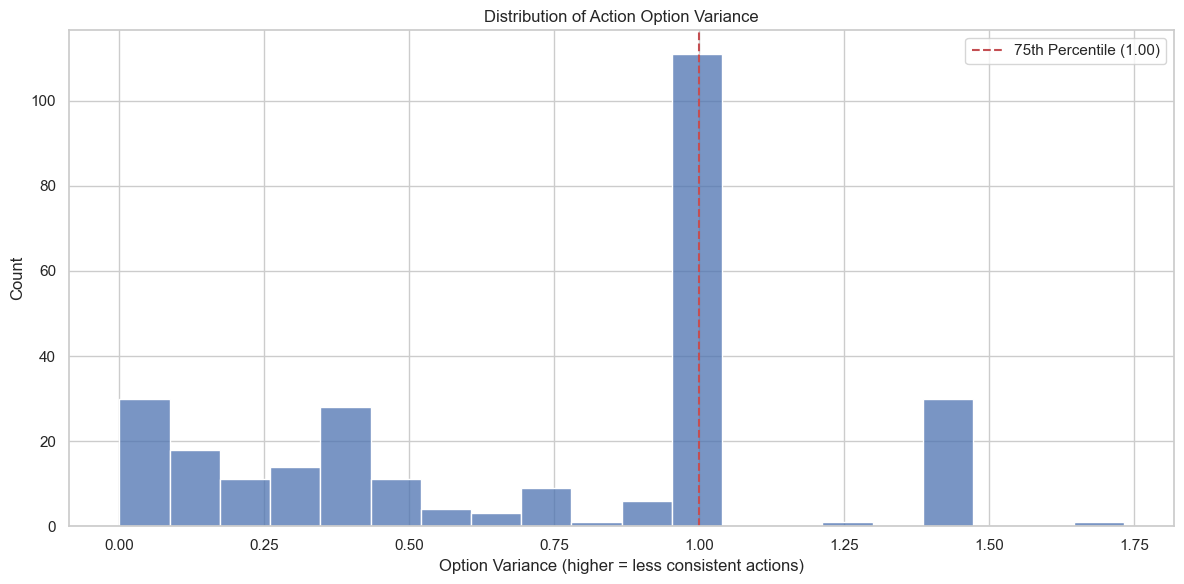

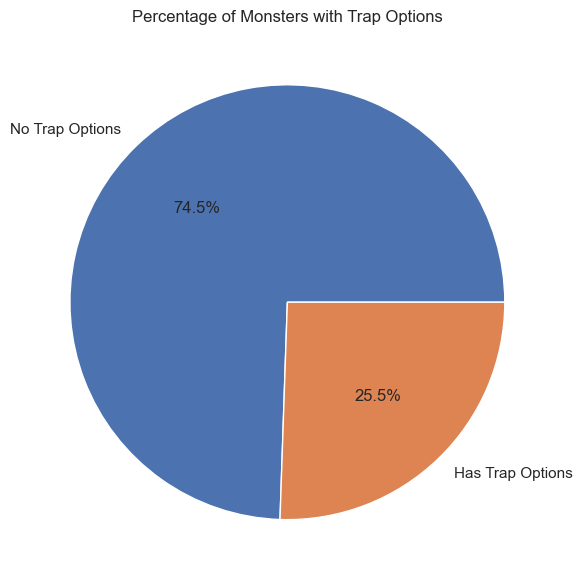

C:\Users\final\AppData\Local\Temp\ipykernel_25596\3154509279.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trap_by_tier = multi_option_monsters.groupby('cr_tier')['has_trap_options'].mean() * 100


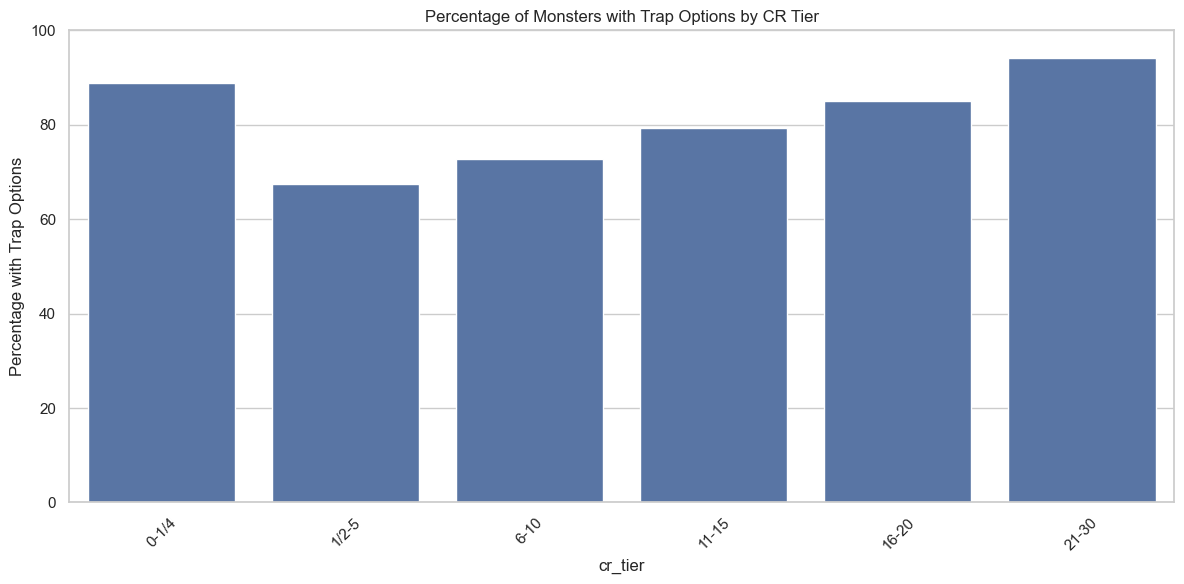


Examples of Trap Options Found:
- Aberrant Cultist (CR 8.0): WARNING: 'mind rot' is only 0% as effective as 'tentacle lash' (0.0 vs 15.9 DPR). This may be a 'trap option' that could significantly reduce the monster's effective CR.
- Aboleth (CR 10.0): WARNING: 'consume memories' is only 0% as effective as 'tentacle' (0.0 vs 28.5 DPR). This may be a 'trap option' that could significantly reduce the monster's effective CR.
- Aboleth (CR 10.0): WARNING: 'dominate mind' is only 0% as effective as 'tentacle' (0.0 vs 28.5 DPR). This may be a 'trap option' that could significantly reduce the monster's effective CR.
- Abominable Yeti (CR 9.0): WARNING: 'ice throw' is only 34% as effective as 'claw' (11.4 vs 33.2 DPR). This may be a 'trap option' that could significantly reduce the monster's effective CR.
- Abominable Yeti (CR 9.0): WARNING: 'chilling gaze' is only 0% as effective as 'claw' (0.0 vs 33.2 DPR). This may be a 'trap option' that could significantly reduce the monster's effective C

In [70]:
def analyze_action_efficiency_patterns(monster_df):
    """
    Analyze patterns in action efficiency across monsters of different CRs
    """
    # Filter to monsters with multiple offensive options
    multi_option_monsters = monster_df[monster_df['has_multiple_options'] == True]
    
    if len(multi_option_monsters) == 0:
        print("No monsters with multiple offensive options found in the dataset.")
        return monster_df
    
    # Calculate average option variance by CR tier
    tier_variance = multi_option_monsters.groupby('cr_tier')['action_option_variance'].agg(['mean', 'median', 'std', 'count'])
    
    print("Action Option Variance by CR Tier:")
    display(tier_variance)
    
    # Identify monsters with highest option variance (potentially problematic designs)
    high_variance_threshold = multi_option_monsters['action_option_variance'].quantile(0.75)
    high_variance_monsters = multi_option_monsters[multi_option_monsters['action_option_variance'] > high_variance_threshold]
    
    print(f"\nMonsters with High Option Variance (above {high_variance_threshold:.2f}):")
    high_var_display = high_variance_monsters[['name', 'cr', 'action_option_variance', 'has_trap_options', 'num_trap_options']].sort_values('action_option_variance', ascending=False)
    display(high_var_display.head(15))
    
    # Plot variance distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(multi_option_monsters['action_option_variance'], bins=20)
    plt.axvline(high_variance_threshold, color='r', linestyle='--', label=f'75th Percentile ({high_variance_threshold:.2f})')
    plt.title('Distribution of Action Option Variance')
    plt.xlabel('Option Variance (higher = less consistent actions)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot trap options by CR
    plt.figure(figsize=(12, 6))
    has_traps = multi_option_monsters['has_trap_options'].value_counts(normalize=True) * 100
    plt.pie(has_traps, labels=['No Trap Options', 'Has Trap Options'], autopct='%1.1f%%')
    plt.title('Percentage of Monsters with Trap Options')
    plt.tight_layout()
    plt.show()
    
    # Plot by CR tier
    trap_by_tier = multi_option_monsters.groupby('cr_tier')['has_trap_options'].mean() * 100
    plt.figure(figsize=(12, 6))
    sns.barplot(x=trap_by_tier.index, y=trap_by_tier.values)
    plt.title('Percentage of Monsters with Trap Options by CR Tier')
    plt.ylabel('Percentage with Trap Options')
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Display examples of common trap options
    if multi_option_monsters['has_trap_options'].sum() > 0:
        trap_monsters = multi_option_monsters[multi_option_monsters['has_trap_options']]
        trap_warnings = []
        
        for _, monster in trap_monsters.head(10).iterrows():
            for warning in monster['design_warnings']:
                if "trap option" in warning:
                    trap_warnings.append(f"{monster['name']} (CR {monster['cr']}): {warning}")
        
        print("\nExamples of Trap Options Found:")
        for warning in trap_warnings:
            print(f"- {warning}")
    
    return monster_df

# Analyze action efficiency patterns
monster_df = analyze_action_efficiency_patterns(monster_df)

## 8. Interactive CR Calculator Widget

In [74]:
def create_cr_calculator():
    """
    Create an interactive widget for calculating CR
    """
    # Create input widgets
    hp_input = widgets.IntSlider(value=100, min=1, max=500, step=10, description='HP:')
    ac_input = widgets.IntSlider(value=15, min=10, max=25, description='AC:')
    dpr_input = widgets.IntSlider(value=20, min=0, max=1000, step=5, description='Dmg/Round:')
    atk_input = widgets.IntSlider(value=5, min=0, max=35, description='Attack Bonus:')
    
    # Defensive traits
    resistances = widgets.IntSlider(value=0, min=0, max=10, description='# Resistances:')
    immunities = widgets.IntSlider(value=0, min=0, max=10, description='# Immunities:')
    
    # Action types
    offensive_actions = widgets.IntSlider(value=1, min=0, max=5, description='Offensive Actions:')
    defensive_actions = widgets.IntSlider(value=0, min=0, max=5, description='Defensive Actions:')
    control_actions = widgets.IntSlider(value=0, min=0, max=5, description='Control Actions:')
    
    # Action economy
    has_bonus = widgets.Checkbox(value=False, description='Has Bonus Action')
    has_reaction = widgets.Checkbox(value=False, description='Has Reaction')
    legendary_slots = widgets.IntSlider(value=0, min=0, max=5, description='Legendary Actions:')
    lair_actions = widgets.Checkbox(value=False, description='Has Lair Actions')
    
    # Special abilities
    spellcasting_checkbox = widgets.Checkbox(value=False, description='Spellcasting')
    spell_dc = widgets.IntSlider(value=12, min=10, max=30, description='Spell DC:')
    
    # Create output widget
    output = widgets.Output()
    
    # Define update function
    def update_cr(*args):
        with output:
            output.clear_output()
            
            # Calculate action economy score
            action_economy = 1  # Base standard action
            action_economy += 0.5 if has_bonus.value else 0
            action_economy += 0.3 if has_reaction.value else 0
            action_economy += 0.3 * legendary_slots.value if legendary_slots.value > 0 else 0
            
            # Calculate effective HP
            effective_hp = hp_input.value * (1 + (resistances.value * 0.05)) * (1 + (immunities.value * 0.1))
            
            # Calculate offensive power
            control_factor = 1 + (control_actions.value * 0.1)
            offensive_power = dpr_input.value * (1 + (atk_input.value / 15))
            offensive_power *= (action_economy / 1.5)  # Normalize to 1.5 (typical action economy)
            offensive_power *= control_factor
            
            # Calculate defensive power
            defensive_power = effective_hp * (ac_input.value / 14)
            defensive_power *= (1 + (defensive_actions.value * 0.15))
            
            # Calculate CR components based on offensive and defensive power
            if offensive_power <= 0:
                offensive_cr = 0
            elif offensive_power <= 5:
                offensive_cr = offensive_power / 6
            elif offensive_power <= 10:
                offensive_cr = offensive_power / 5 - 0.2
            elif offensive_power <= 20:
                offensive_cr = offensive_power / 4 - 0.7
            elif offensive_power <= 40:
                offensive_cr = offensive_power / 3 - 3
            else:
                offensive_cr = offensive_power / 2.5 - 6
            
            if defensive_power <= 0:
                defensive_cr = 0
            elif defensive_power <= 35:
                defensive_cr = defensive_power / 50
            elif defensive_power <= 70:
                defensive_cr = defensive_power / 35 - 0.5
            elif defensive_power <= 140:
                defensive_cr = defensive_power / 25 - 1.5
            elif defensive_power <= 280:
                defensive_cr = defensive_power / 20 - 3
            else:
                defensive_cr = defensive_power / 15 - 8
            
            # Calculate final CR
            estimated_cr = (offensive_cr + defensive_cr) / 2
            
            # Round to nearest standard CR
            standard_crs = [0, 0.125, 0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                           11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
            
            rounded_cr = min(standard_crs, key=lambda x: abs(x - estimated_cr))
            
            # XP table
            xp_table = {
                0: 0, 0.125: 25, 0.25: 50, 0.5: 100, 1: 200, 2: 450, 3: 700, 4: 1100, 5: 1800,
                6: 2300, 7: 2900, 8: 3900, 9: 5000, 10: 5900, 11: 7200, 12: 8400, 13: 10000,
                14: 11500, 15: 13000, 16: 15000, 17: 18000, 18: 20000, 19: 22000, 20: 25000,
                21: 33000, 22: 41000, 23: 50000, 24: 62000, 25: 75000, 26: 90000, 27: 105000,
                28: 120000, 29: 135000, 30: 155000
            }
            
            xp = xp_table.get(rounded_cr, 0)
            
            # Display results
            print(f"Action Economy Score: {action_economy:.2f}")
            print(f"Effective HP: {effective_hp:.1f}")
            print(f"Offensive Power: {offensive_power:.1f}")
            print(f"Defensive Power: {defensive_power:.1f}")
            print(f"\nOffensive CR: {offensive_cr:.2f}")
            print(f"Defensive CR: {defensive_cr:.2f}")
            print(f"Estimated CR: {estimated_cr:.2f}")
            print(f"Rounded CR: {rounded_cr}")
            print(f"XP Value: {xp}")
    
    # Connect widgets to update function
    for widget in [hp_input, ac_input, dpr_input, atk_input, resistances, immunities,
                  offensive_actions, defensive_actions, control_actions,
                  has_bonus, has_reaction, legendary_slots, lair_actions,
                  spellcasting_checkbox, spell_dc]:
        widget.observe(update_cr, 'value')
    
    # Create tabs for better organization
    basic_tab = widgets.VBox([
        widgets.HTML("<h3>Basic Stats</h3>"),
        widgets.HBox([hp_input, ac_input]),
        widgets.HBox([dpr_input, atk_input]),
        widgets.HBox([resistances, immunities])
    ])
    
    action_tab = widgets.VBox([
        widgets.HTML("<h3>Action Types</h3>"),
        widgets.HBox([offensive_actions, defensive_actions]),
        widgets.HBox([control_actions]),
        widgets.HTML("<h3>Action Economy</h3>"),
        widgets.HBox([has_bonus, has_reaction]),
        widgets.HBox([legendary_slots, lair_actions])
    ])
    
    special_tab = widgets.VBox([
        widgets.HTML("<h3>Special Abilities</h3>"),
        widgets.HBox([spellcasting_checkbox, spell_dc])
    ])
    
    tabs = widgets.Tab(children=[basic_tab, action_tab, special_tab])
    tabs.set_title(0, 'Basic Stats')
    tabs.set_title(1, 'Actions')
    tabs.set_title(2, 'Special')
    
    # Create main widget
    main_widget = widgets.VBox([
        widgets.HTML("<h2>D&D 5e 2024 Challenge Rating Calculator</h2>"),
        tabs,
        widgets.HTML("<h3>Results:</h3>"),
        output
    ])
    
    # Initialize
    update_cr()
    
    return main_widget

# Display the calculator widget
create_cr_calculator()

## Conclusion and Next Steps

This analysis provides a framework for understanding how monster statistics relate to Challenge Ratings in the 2024 D&D rules. The derived formulas and models can help DMs create balanced homebrew monsters by estimating their CR based on their stats.

Key findings:
1. TBD

### Next Steps

1. **Expand the dataset**: Convert monsters from the SRD to ingestible data
2. **Refine the models**: Update based on playtesting feedback
3. **Validate against official monsters**: Compare predictions with official CRs
4. **Create tools**: Develop full-featured monster builders using these insights
5. **Test edge cases**: Analyze monsters with unusual ability combinations